In [149]:
import pandas as pd
import numpy as np

#Plotting liibs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# fuzz is used to compare TWO strings
from fuzzywuzzy import fuzz
# process is used to compare a string to MULTIPLE other strings
from fuzzywuzzy import process

# ML libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


In [150]:
go.subplots.make_subplots(1,2, shared_yaxes = True)

AttributeError: module 'plotly.graph_objects' has no attribute 'subplots'

In [3]:
# Set up the StatsBomb data loader
SBL = StatsBombLoader()

# View all available competitions
df_competitions = SBL.competitions()

In [4]:
# get all the seasons in the dataset for the FA Women's Super League, which the target competion
competition_seasons = df_competitions[df_competitions['competition_name'] == "FA Women's Super League"]
competition_seasons

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
15,90,37,FA Women's Super League,England,female,2020/2021
16,42,37,FA Women's Super League,England,female,2019/2020
17,4,37,FA Women's Super League,England,female,2018/2019


In [5]:
# Create a dataframe with all games from FA Women's Super League 2020/2021 season as our model test dataset

# Create a dataframe with all the games in the previous 2 seasons as our train and validation set

df_games_season_4 = SBL.games(competition_id=37, season_id=4).set_index("game_id")
df_games_season_42 = SBL.games(competition_id=37, season_id=42).set_index("game_id")
df_games = pd.concat([df_games_season_4, df_games_season_42], axis=0)
df_games_test = SBL.games(competition_id=37, season_id=90).set_index("game_id")


In [6]:
df_games.shape

(195, 11)

In [7]:
df_games.head()

,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
7298,4,37,Regular Season,0,2018-02-24 20:45:00,746,971,2,2,Academy Stadium,Darren England
19778,4,37,Regular Season,12,2018-12-09 13:15:00,746,969,1,0,Academy Stadium,Rebecca Welch
19771,4,37,Regular Season,11,2018-12-02 15:00:00,969,970,2,1,\tARMCO Arena,Jane Simms
19736,4,37,Regular Season,5,2018-10-14 15:00:00,971,968,0,5,Kingsmeadow,Sam Purkiss
19745,4,37,Regular Season,7,2018-10-28 15:00:00,965,970,2,1,Broadfield Stadium,Jacob Miles


We have 195 games with 11 attributes each. 

### Explore a single game

In [8]:
# for the chose match_id, get the teams involved, players and events

game_id = 7298
df_teams = SBL.teams(game_id)
df_players = SBL.players(game_id)
df_events = SBL.events(game_id)

In [9]:
df_teams.head()

,team_id,team_name
0,971,Chelsea FCW
1,746,Manchester City WFC


In [10]:
df_players.head()

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7298,971,4633,Magdalena Lilly Eriksson,None,16,True,5,Left Center Back,97
1,7298,971,4636,Maria Thorisdottir,None,2,False,0,Substitute,12
2,7298,971,4638,Drew Spence,None,24,True,15,Left Center Midfield,58
3,7298,971,4640,Rut Hedvig Lindahl,Hedvig Lindahl,1,True,1,Goalkeeper,97
4,7298,971,4641,Francesca Kirby,None,14,True,22,Right Center Forward,85


In [11]:
df_events.head()

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
0,7298,0b483cd2-1d36-49a0-85c2-149a9de553df,1,746,NaN,35,Starting XI,1,1900-01-01 00:00:00.000,0,...,Manchester City WFC,0.00,"{'tactics': {'formation': 433, 'lineup': [{'pl...",[],NaN,NaN,NaN,NaN,False,False
1,7298,2c873afb-73bb-48a1-9fd5-bfe1400b4a83,1,971,NaN,35,Starting XI,2,1900-01-01 00:00:00.000,0,...,Chelsea FCW,0.00,"{'tactics': {'formation': 352, 'lineup': [{'pl...",[],NaN,NaN,NaN,NaN,False,False
2,7298,040940a1-5972-431e-b6ac-e723edd8e7c2,1,746,NaN,18,Half Start,3,1900-01-01 00:00:00.000,0,...,Manchester City WFC,7.96,{},[5ba286bd-c397-4ac4-b12f-6bace943afce],NaN,NaN,NaN,NaN,False,False
3,7298,5ba286bd-c397-4ac4-b12f-6bace943afce,1,971,NaN,18,Half Start,4,1900-01-01 00:00:00.000,0,...,Chelsea FCW,8.16,{},[040940a1-5972-431e-b6ac-e723edd8e7c2],NaN,NaN,NaN,NaN,False,False
4,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,971,4647.0,30,Pass,5,1900-01-01 00:00:00.100,0,...,Chelsea FCW,0.00,"{'pass': {'recipient': {'id': 4659, 'name': 'R...",[483b7286-e75e-4191-80be-ac93bfed1473],So-Yun Ji,14.0,Center Midfield,"[61.0, 40.0]",False,False


In [12]:
home_team_id = df_games.at[game_id, "home_team_id"]
df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)

In [13]:
df_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,0.0,971,4647.0,52.058824,33.569620,50.294118,30.987342,0,1,0,0
1,7298,7e908bd8-8e2f-44f8-9cc6-0435cd9ed3ed,1,0.0,971,4659.0,50.294118,30.987342,45.000000,27.544304,21,1,0,1
2,7298,38023613-6b26-44e2-a0f8-9aab9960d2ff,1,0.0,971,4659.0,45.000000,27.544304,31.764706,3.443038,0,1,0,2
3,7298,0d016edd-87cf-4e77-80fa-4504f367db00,1,2.0,971,5088.0,31.764706,3.443038,10.588235,7.746835,21,1,0,3
4,7298,ccb57323-17d3-43db-8ae4-0d170c59c9cb,1,6.0,971,5088.0,10.588235,7.746835,10.588235,7.746835,19,0,0,4


In [14]:
df_actions = spadl.add_names(df_actions)
df_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name
0,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,0.0,971,4647.0,52.058824,33.569620,50.294118,30.987342,0,1,0,0,pass,success,foot
1,7298,7e908bd8-8e2f-44f8-9cc6-0435cd9ed3ed,1,0.0,971,4659.0,50.294118,30.987342,45.000000,27.544304,21,1,0,1,dribble,success,foot
2,7298,38023613-6b26-44e2-a0f8-9aab9960d2ff,1,0.0,971,4659.0,45.000000,27.544304,31.764706,3.443038,0,1,0,2,pass,success,foot
3,7298,0d016edd-87cf-4e77-80fa-4504f367db00,1,2.0,971,5088.0,31.764706,3.443038,10.588235,7.746835,21,1,0,3,dribble,success,foot
4,7298,ccb57323-17d3-43db-8ae4-0d170c59c9cb,1,6.0,971,5088.0,10.588235,7.746835,10.588235,7.746835,19,0,0,4,bad_touch,fail,foot


In [15]:
# Find a goal to visualise later

df_actions[(df_actions['type_name']=='shot') & (df_actions['result_name']=='success')]

# goals at index 138, 523, 1199, 1977


,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name
138,7298,3f0fc8e9-a09f-480a-9396-132e1ca05ec5,1,346.0,971,4642.0,10.588235,26.683544,0.0,36.324051,11,1,0,138,shot,success,foot
523,7298,13933d30-56e3-4900-b942-0ee01af8ed1f,1,1401.0,971,4647.0,10.588235,30.126582,0.0,36.668354,11,1,0,523,shot,success,foot
1199,7298,3279e6e0-c796-4871-aaaa-75344dc903b8,2,221.0,746,4654.0,100.588235,33.569620,105.0,33.827848,11,1,1,1199,shot,success,head
1977,7298,12092a46-bc36-4f00-91f6-767ef8601ae1,2,2434.0,746,4643.0,85.588235,29.265823,105.0,31.159494,11,1,0,1977,shot,success,foot


In [16]:
df_actions = spadl.play_left_to_right(df_actions, home_team_id=home_team_id)

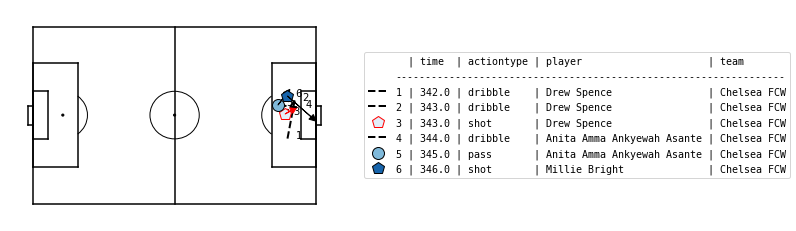

In [17]:
# Select relevant actions
df_actions_goal = df_actions.loc[138 - 5: 138]
# Replace result, actiontype and bodypart IDs by their corresponding name
df_actions_goal = spadl.add_names(df_actions_goal)
# Add team and player names
df_actions_goal = df_actions_goal.merge(df_teams).merge(df_players)
# Create the plot
mps.actions(
    location=df_actions_goal[["start_x", "start_y", "end_x", "end_y"]],
    action_type=df_actions_goal.type_name,
    team=df_actions_goal.team_name,
    result=df_actions_goal.result_name == "success",
    label=df_actions_goal[["time_seconds", "type_name", "player_name", "team_name"]],
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False
)

In [18]:
# 1. Load a set of actions to train the model on
actions = df_actions

# 2. Train xT model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(actions)

# 3. Rate ball-progressing actions
# xT should only be used to value actions that move the ball
# and that keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(actions)
mov_actions["xT_value"] = xTModel.predict(mov_actions)

# iterations:  45


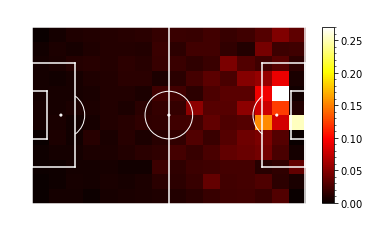

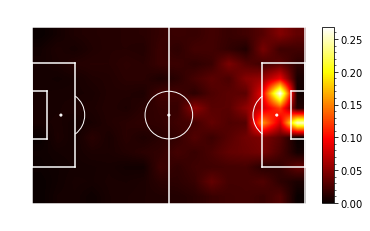

<AxesSubplot:>

In [19]:
# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

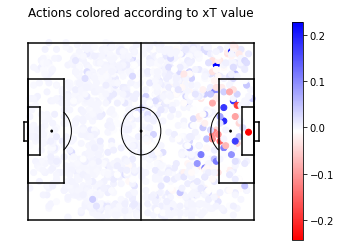

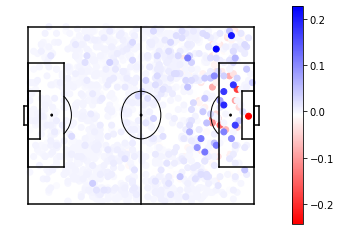

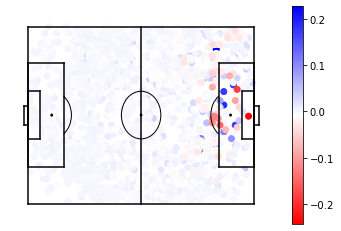

In [20]:
## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

## Convert training dataset to SPADL Schema and compute VAEP Score for all actions

In [22]:
VAEP_model = VAEP(nb_prev_actions=5)

# compute features and labels for each game
all_features, all_labels, all_actions = [], [], []
for game_id, game in tqdm(list(df_games.iterrows())):
    
    # load the game's events
    game_events = SBL.events(game_id)
    
    # convert the events to actions
    game_home_team_id = df_games.at[game_id, "home_team_id"]
    game_actions = spadl.statsbomb.convert_to_actions(game_events, game_home_team_id)
    game_actions = socceraction.spadl.add_names(game_actions)
    
    # compute features and labels
    all_actions.append(game_actions)
    all_features.append(VAEP_model.compute_features(game, game_actions))
    all_labels.append(VAEP_model.compute_labels(game, game_actions))

# combine all features and labels in a single dataframe
all_actions = pd.concat(all_actions)
all_features = pd.concat(all_features)
all_labels = pd.concat(all_labels)

# fit the model
VAEP_model.fit(all_features, all_labels)

100%|██████████| 195/195 [06:46<00:00,  2.09s/it]


[0]	validation_0-auc:0.77402
[1]	validation_0-auc:0.77522
[2]	validation_0-auc:0.77551
[3]	validation_0-auc:0.77551
[4]	validation_0-auc:0.79949
[5]	validation_0-auc:0.80661
[6]	validation_0-auc:0.80933
[7]	validation_0-auc:0.80943
[8]	validation_0-auc:0.81170
[9]	validation_0-auc:0.81590
[10]	validation_0-auc:0.81756
[11]	validation_0-auc:0.81736
[12]	validation_0-auc:0.81740
[13]	validation_0-auc:0.81779
[14]	validation_0-auc:0.81797
[15]	validation_0-auc:0.81820
[16]	validation_0-auc:0.81843
[17]	validation_0-auc:0.82142
[18]	validation_0-auc:0.82248
[19]	validation_0-auc:0.82415
[20]	validation_0-auc:0.82636
[21]	validation_0-auc:0.82778
[22]	validation_0-auc:0.82846
[23]	validation_0-auc:0.83006
[24]	validation_0-auc:0.83179
[25]	validation_0-auc:0.83220
[26]	validation_0-auc:0.83300
[27]	validation_0-auc:0.83338
[28]	validation_0-auc:0.83343
[29]	validation_0-auc:0.83296
[30]	validation_0-auc:0.83481
[31]	validation_0-auc:0.83453
[32]	validation_0-auc:0.83439
[33]	validation_0-au

In [23]:
VAEP_ratings = []
for game_id, game in tqdm(list(df_games.iterrows())):
    df_events = SBL.events(game_id)
    home_team_id = df_games.at[game_id, "home_team_id"]
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id)
    ratings = VAEP_model.rate(df_games.loc[game_id], df_actions)
    VAEP_ratings.append(ratings)

100%|██████████| 195/195 [09:46<00:00,  3.01s/it]


In [24]:
VAEP_ratings = pd.concat(VAEP_ratings)
rated_df = pd.concat([all_actions, VAEP_ratings], axis=1)

## Compute xT for each action

In [25]:
# 1. Convert direction of play
actions_ltr = pd.concat([
  spadl.play_left_to_right(all_actions[all_actions['game_id'] == game_id], game.home_team_id)
  for game_id, game in df_games.iterrows()
])

actions_ltr = socceraction.spadl.add_names(actions_ltr)
actions_ltr['original_index']=actions_ltr.index

# 3. Train xT model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(actions_ltr)

# 4. Rate ball-progressing actions
# xT should only be used to value actions that move the ball
# and that keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(actions_ltr)
mov_actions["xT_value"] = xTModel.predict(mov_actions)

# iterations:  38


In [26]:
print(f'rated_df shape: {rated_df.shape}')
print(f'move_actions shape: {mov_actions.shape}')

rated_df shape: (375518, 20)
move_actions shape: (267218, 19)


## Creating new Features

### Features to add in

**Notebooks:**

- Single match exploration and variables/data discovery
- Data prep across seasons - build main dataset and split into test/validate/test
- Statistical testing inputs against targets
- Clustering player targets, predicting next actions, validating and testing 
- Predicting transfers
- Evaluating Models - Confusion Matrix, ROC Curve
- Final findings 


**Input Features:**

- 'game_id' - maybe (might need it to generate features, but drop before feeding model)
- 'original_event_id' - maybe
- 'period_id' 
- 'time_seconds' - maybe
- 'team_id',   
- 'player_id', 
- 'start_x', 
- 'start_y', 


These would not feed into the model, as they wouldnt be known yet for the line I am running prediction on - they should be represented in the n-x columns only as part of the previous moves. 

```
- 'end_x', 
- 'end_y',
- 'type_id',
- 'result_id', 
- 'bodypart_id', 
- 'action_id', 
- 'type_name', 
- 'result_name',
- 'bodypart_name', 
```


**To add:**
- Distance X
- Distance Y 
- 'start_pitch_zone'
- end_pitch_zone
- opponent
- home (how would this work when getting predictions? and when training)
- away

**For actions n-5:**
(if using a dataset with multiple matches, make sure they are from the same game)
- Prev_action_n-x_x_distance
- Prev_action_n-x_y_distance
- n-x_same_team
- n-x_same_player
- n-x_x_direction 
- n-x_y_direction
- n-x_action
- n-x_pitch_zone

**Target output:**

- Type of action 
- Next Zone

```some of these will need to be dummied```

**Football Scoring Metrics**
- xT per action 
- VAEP 
- aggregates at player level

Then swap the player ID for the player that we'd want to swap in to create a prediction dataset. 
(see if there is a transfer within the datast we could use as validation of the model)

- use the first 2 seasons for train and validate and the last season for test 
- predict the actions of players that had a transfer between season 2 and 3 - to test how the prediction does 

Each line of data should be standalone, rather than sequential - transforming sequential - time series type data - into non-sequential data

Then xT and VEAP output

In [27]:
rated_df.reset_index(drop=True, inplace=True)
rated_df.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,offensive_value,defensive_value,vaep_value
0,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,0.0,971,4647.0,52.058824,33.569620,50.294118,30.987342,0,1,0,0,pass,success,foot,0.000000,-0.000000,0.000000
1,7298,7e908bd8-8e2f-44f8-9cc6-0435cd9ed3ed,1,0.0,971,4659.0,50.294118,30.987342,45.000000,27.544304,21,1,0,1,dribble,success,foot,0.000000,0.000186,0.000186
2,7298,38023613-6b26-44e2-a0f8-9aab9960d2ff,1,0.0,971,4659.0,45.000000,27.544304,31.764706,3.443038,0,1,0,2,pass,success,foot,0.000145,0.000051,0.000196
3,7298,0d016edd-87cf-4e77-80fa-4504f367db00,1,2.0,971,5088.0,31.764706,3.443038,10.588235,7.746835,21,1,0,3,dribble,success,foot,0.007753,-0.000000,0.007753
4,7298,ccb57323-17d3-43db-8ae4-0d170c59c9cb,1,6.0,971,5088.0,10.588235,7.746835,10.588235,7.746835,19,0,0,4,bad_touch,fail,foot,-0.008372,-0.000073,-0.008445


In [28]:
df_actions_zones = rated_df.copy()

matches = []
for game_id, game in df_games.iterrows():
    # # load the game's events
    # game_events = SBL.events(game_id)
    # convert play left to right
    game_home_team_id = df_games.at[game_id, "home_team_id"]
    matches.append(spadl.play_left_to_right(df_actions_zones[df_actions_zones['game_id'] == game_id], home_team_id=game_home_team_id))

df_actions_zones = pd.concat(matches)

In [29]:
players = []
for game_id, game in tqdm(list(df_games.iterrows())):
    
    # load the games players
    players.append(SBL.players(game_id))


players = pd.concat(players, ignore_index=True)

100%|██████████| 195/195 [02:57<00:00,  1.10it/s]


In [30]:
goal_keepers = players[players['starting_position_id'] == 1].drop_duplicates(subset='player_name')

In [31]:
goal_keepers = goal_keepers[['player_id', 'player_name']]

In [32]:
zones = []
end_zones = []

for i, row in df_actions_zones.iterrows():
    if ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_1')
    elif ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_2')
    elif ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_3')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_4')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_5')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_6')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_7')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_8')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_9')
    else:
        zones.append('no_zone')

for i, row in df_actions_zones.iterrows():
    if ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_1')
    elif ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_2')
    elif ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_3')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_4')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_5')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_6')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_7')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_8')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_9')
    else:
        end_zones.append('no_zone')

df_actions_zones['start_pitch_zone'] = zones
df_actions_zones['end_pitch_zone'] = end_zones


In [33]:
mov_actions_with_zones = mov_actions.copy()

In [34]:
zones = []
end_zones = []

for i, row in mov_actions_with_zones.iterrows():
    if ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_1')
    elif ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_2')
    elif ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_3')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_4')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_5')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_6')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_7')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_8')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_9')
    else:
        zones.append('no_zone')

for i, row in mov_actions_with_zones.iterrows():
    if ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_1')
    elif ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_2')
    elif ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_3')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_4')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_5')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_6')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_7')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_8')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_9')
    else:
        end_zones.append('no_zone')

mov_actions_with_zones['start_pitch_zone'] = zones
mov_actions_with_zones['end_pitch_zone'] = end_zones

In [36]:
# opposition 
matches = list(df_actions_zones['game_id'].unique())
match_teams = {match: list(df_actions_zones[df_actions_zones['game_id'] == match]['team_id'].unique()) for match in matches}

df_actions_zones['opponent_id'] = [match_teams[k][1] if match_teams[k][0] == row['team_id'] else match_teams[k][0] \
     for i, row in df_actions_zones.iterrows() \
        for k, v in match_teams.items() \
            if row['game_id'] == k]

# update action type to pass/dribble/other to deal with class imbalance
df_actions_zones['type_name_encoded'] = ['pass' if x =='pass' else\
     ('dribble' if x =='dribble' else 'other')\
         for x in df_actions_zones['type_name']]

# Home or Away
df_actions_zones['home'] = [1 if np.array(df_games[df_games.index == row['game_id']]['home_team_id'] == row['team_id'])[0] \
    else 0 for i, row in df_actions_zones.iterrows() \
        for match in matches if row['game_id'] == match]

# x and y distance traveled 
df_actions_zones['x_dif'] = (df_actions_zones['end_x'] - df_actions_zones['start_x'])
df_actions_zones['y_dif'] = (df_actions_zones['end_y'] - df_actions_zones['start_y'])

#prior moves
print('Starting prior moves block')
for n in range(1,6):
    df_actions_zones[f'n-{n}_x_distance'] = df_actions_zones.groupby('game_id').shift(n)[['x_dif']]
    df_actions_zones[f'n-{n}_y_distance'] = df_actions_zones.groupby('game_id').shift(n)[['y_dif']]
    df_actions_zones[f'n-{n}_same_team'] = df_actions_zones.team_id.eq(df_actions_zones.team_id.shift(n))
    df_actions_zones[f'n-{n}_same_player'] = df_actions_zones.player_id.eq(df_actions_zones.player_id.shift(n))
    df_actions_zones[f'n-{n}_x_fwd_direction'] = [1 if row['x_dif'] > 0 else 0 for i, row in df_actions_zones.groupby('game_id').shift(n).iterrows()]
    df_actions_zones[f'n-{n}_y_lft_right_direction'] = [1 if row['y_dif'] > 0 else 0 for i, row in df_actions_zones.groupby('game_id').shift(n).iterrows()]
    df_actions_zones[f'n-{n}_start_pitch_zone'] = df_actions_zones.groupby('game_id').shift(n)[['start_pitch_zone']]
    df_actions_zones[f'n-{n}_end_pitch_zone'] = df_actions_zones.groupby('game_id').shift(n)[['end_pitch_zone']]
    df_actions_zones[f'n-{n}_start_x'] = df_actions_zones.groupby('game_id').shift(n)[['start_x']]
    df_actions_zones[f'n-{n}_start_y'] = df_actions_zones.groupby('game_id').shift(n)[['start_y']]
    df_actions_zones[f'n-{n}_end_x'] = df_actions_zones.groupby('game_id').shift(n)[['end_x']]
    df_actions_zones[f'n-{n}_end_y'] = df_actions_zones.groupby('game_id').shift(n)[['end_y']]
    df_actions_zones[f'n-{n}_type_name'] = df_actions_zones.groupby('game_id').shift(n)[['type_name']]
    df_actions_zones[f'n-{n}_type_name_encoded'] = df_actions_zones.groupby('game_id').shift(n)[['type_name_encoded']]
    df_actions_zones[f'n-{n}_result_name'] = df_actions_zones.groupby('game_id').shift(n)[['result_name']]
    df_actions_zones[f'n-{n}_bodypart_name'] = df_actions_zones.groupby('game_id').shift(n)[['bodypart_name']]
    df_actions_zones[f'n-{n}_offensive_value'] = df_actions_zones.groupby('game_id').shift(n)[['offensive_value']]
    df_actions_zones[f'n-{n}_defensive_value'] = df_actions_zones.groupby('game_id').shift(n)[['defensive_value']]
    df_actions_zones[f'n-{n}_vaep_value'] = df_actions_zones.groupby('game_id').shift(n)[['vaep_value']]
    # df_actions_zones[f'n-{n}_type_id'] = df_actions_zones.groupby('game_id').shift(n)[['type_id']]
    # df_actions_zones[f'n-{n}_result_id'] = df_actions_zones.groupby('game_id').shift(n)[['result_id']]
    # df_actions_zones[f'n-{n}_bodypart_id'] = df_actions_zones.groupby('game_id').shift(n)[['bodypart_id']]

Starting prior moves block


TO DO:

0. add a notebook 1 with a single match exploration - this becomes notebook 2 
1. group by zones and add in xT & VAEP Scores 
2. Visualise those 
3. Find top players for each team by xT for their end locations 
4. Calculate the xT difference between the start and end location 
5. EDA into notebook 2 - add in 5 EDA sections
    - zone analysis
    - top players
    - heatmaps for passes/dribbles/crosses and end_zones 
    - distance analysis 

other:
- modify code to add in seasons 1,2 - create season 3 as a separate test dataset 
- find player transfers


## Data Analysis on Training Set

In [37]:
xt_zone_values = mov_actions_with_zones[['end_pitch_zone', 'xT_value']].groupby('end_pitch_zone').mean().reset_index()

In [38]:
vaep_zone_values = df_actions_zones[['end_pitch_zone', 'vaep_value']].groupby('end_pitch_zone').mean().reset_index()

In [39]:
zone_values = pd.concat([vaep_zone_values, xt_zone_values['xT_value']], axis=1)

In [40]:
action_vaep = df_actions_zones[['type_name', 'vaep_value']].groupby('type_name').mean().reset_index()

In [41]:
action_vaep['vaep_sum'] = df_actions_zones[['type_name', 'vaep_value']].groupby('type_name').sum().reset_index()['vaep_value']

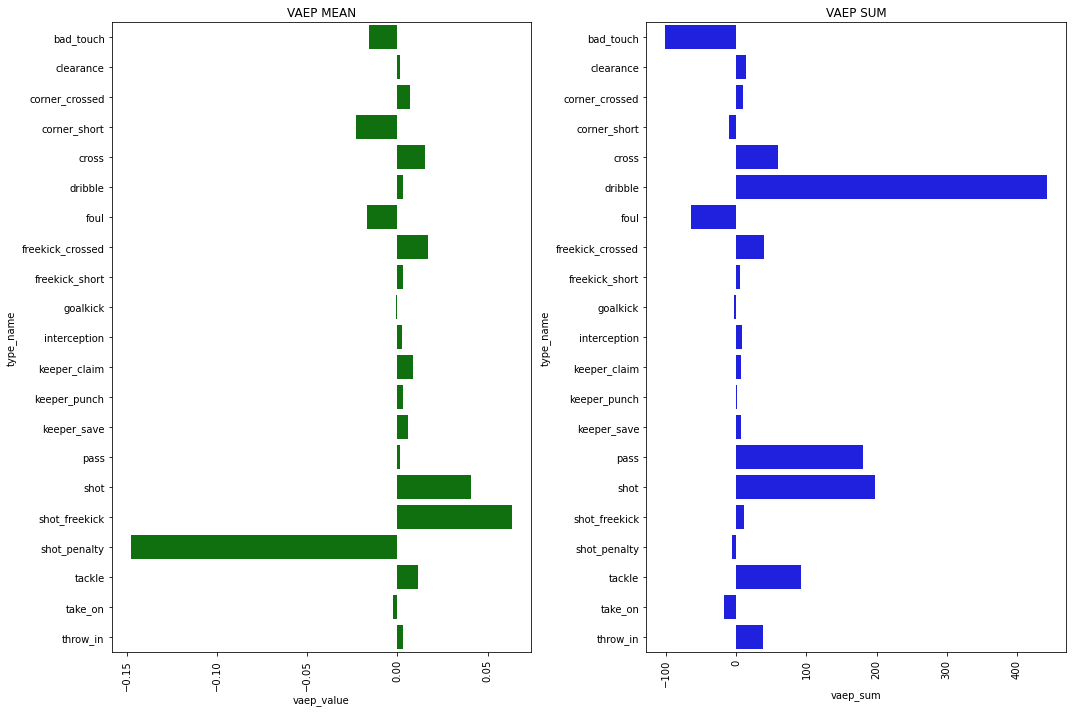

In [42]:
plt.subplots(2,1, figsize=(15,10))

plt.subplot(1,2,1)
sns.barplot(y=action_vaep['type_name'], x=action_vaep['vaep_value'], color='green')
plt.xticks(rotation='90')
plt.title('VAEP MEAN')


plt.subplot(1,2,2)
sns.barplot(y=action_vaep['type_name'], x=action_vaep['vaep_sum'], color='blue')
plt.xticks(rotation='90')
plt.title('VAEP SUM')


plt.tight_layout()
plt.show()

In [43]:
df_actions_zones[(df_actions_zones['type_name']=='shot') & (df_actions_zones['result_name']=='success')].head(10)

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,n-5_start_y,n-5_end_x,n-5_end_y,n-5_type_name,n-5_type_name_encoded,n-5_result_name,n-5_bodypart_name,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value
138,7298,3f0fc8e9-a09f-480a-9396-132e1ca05ec5,1,346.0,971,4642.0,94.411765,41.316456,105.000000,31.675949,...,24.962025,97.058824,39.594937,dribble,dribble,success,foot,0.118759,0.001047,0.119807
523,7298,13933d30-56e3-4900-b942-0ee01af8ed1f,1,1401.0,971,4647.0,94.411765,37.873418,105.000000,31.331646,...,20.658228,82.941176,30.987342,pass,pass,success,foot,-0.022971,0.000100,-0.022871
1199,7298,3279e6e0-c796-4871-aaaa-75344dc903b8,2,221.0,746,4654.0,100.588235,33.569620,105.000000,33.827848,...,64.556962,60.000000,57.670886,pass,pass,success,foot,-0.000061,0.000819,0.000758
1977,7298,12092a46-bc36-4f00-91f6-767ef8601ae1,2,2434.0,746,4643.0,85.588235,29.265823,105.000000,31.159494,...,32.708861,90.882353,19.797468,pass,pass,success,foot,-0.011128,0.000390,-0.010737
2458,19778,d78b5024-c498-48f3-8979-b72e575ac84b,1,709.0,746,4643.0,102.352941,43.037975,105.000000,30.987342,...,19.797468,3.529412,20.658228,dribble,dribble,success,foot,-0.000218,-0.001143,-0.001361
5565,19771,f4d2311a-c176-4761-8e13-5cc626fb490f,2,291.0,969,15562.0,97.058824,42.177215,104.117647,31.331646,...,38.734177,55.588235,38.734177,dribble,dribble,success,foot,-0.000065,-0.000008,-0.000072
6465,19771,efa573c6-1cca-4c51-8e46-f848fa1b5c72,2,2852.0,970,15716.0,98.823529,34.430380,105.000000,32.020253,...,20.658228,87.352941,18.075949,dribble,dribble,success,foot,0.003920,0.000227,0.004147
7330,19736,f31721b3-2495-4f8b-aa4d-948889c5dfe7,1,2225.0,968,15623.0,90.882353,39.594937,104.117647,35.893671,...,41.316456,53.823529,50.784810,pass,pass,success,foot,0.008277,0.001837,0.010114
7601,19736,06aa93ad-015e-4cac-ae32-745276b4d5cf,2,389.0,968,10192.0,91.764706,9.468354,105.000000,37.701266,...,65.417722,37.941176,65.417722,tackle,other,success,foot,0.004128,0.005417,0.009546
7692,19736,e78e001b-34e4-49d4-bf41-ae8f83a13b95,2,695.0,968,15623.0,98.823529,37.012658,104.117647,30.987342,...,36.151899,100.588235,36.496203,shot,other,fail,foot,-0.214975,0.000143,-0.214832


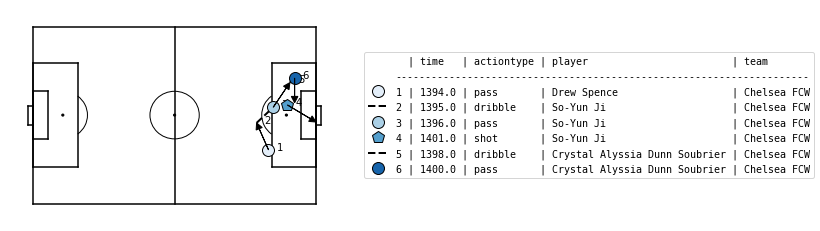

In [44]:
# Select relevant actions
df_actions_goal = df_actions_zones.loc[523 - 5: 523]
# # Replace result, actiontype and bodypart IDs by their corresponding name
# df_actions_goal = spadl.add_names(df_actions_goal)
# Add team and player names
df_actions_goal = df_actions_goal.merge(df_teams).merge(df_players)
# Create the plot
mps.actions(
    location=df_actions_goal[["start_x", "start_y", "end_x", "end_y"]],
    action_type=df_actions_goal.type_name,
    team=df_actions_goal.team_name,
    result=df_actions_goal.result_name == "success",
    label=df_actions_goal[["time_seconds", "type_name", "player_name", "team_name"]],
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False
)

#### Obserservations on VAEP and Action Type

- passes and dribbles have fairly small average scores - however, this is due to volume, when looking at the sum of those, we see greater contribution 
- here we get to see the high value of less frequent actions such as freekicks 

In [45]:
df_actions_zones.groupby('end_pitch_zone').describe()['x_dif'].reset_index()

,end_pitch_zone,count,mean,std,min,25%,50%,75%,max
0,zone_1,33741.0,1.177404,8.578404,-50.294118,-1.764706,0.000000,5.294118,34.411765
1,zone_2,40266.0,-1.158316,9.129341,-61.764706,-4.411765,0.000000,3.264706,32.647059
2,zone_3,35271.0,1.080875,8.505854,-51.176471,-1.764706,0.000000,5.294118,34.323529
3,zone_4,59776.0,5.739064,12.604037,-61.764706,0.000000,1.588235,10.411765,64.852941
4,zone_5,42529.0,4.183592,12.009782,-47.647059,-0.882353,0.882353,7.941176,67.058824
5,zone_6,57249.0,5.552102,12.394690,-43.235294,-0.352941,1.235294,10.411765,67.058824
6,zone_7,39257.0,8.618291,14.836832,-33.529412,0.000000,3.176471,13.235294,97.058824
7,zone_8,34039.0,8.116991,13.384676,-31.500000,0.000000,3.529412,13.235294,93.529412
8,zone_9,33390.0,8.699318,15.144503,-31.764706,0.000000,3.000000,14.117647,99.705882


In [46]:
zone_values = pd.concat([zone_values, df_actions_zones.groupby('end_pitch_zone').describe()['x_dif'].reset_index().drop(columns=['end_pitch_zone'])], axis=1)

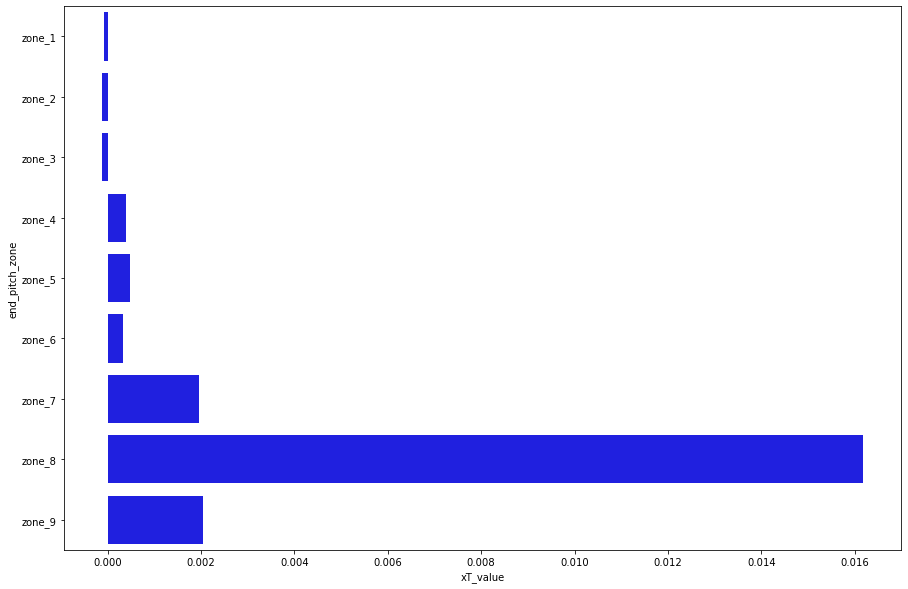

In [47]:
plt.figure(figsize=(15,10))
sns.barplot(y=zone_values['end_pitch_zone'], x=zone_values['xT_value'], color='blue')
plt.show()

#### Observations on xT Value and Pitch Zone

- Zone 8 has the largest mean xT score, which is to be expected as this is where the goal is and therefore it's likely to have more shots and goals from those positions 
- Zones 7 & 9 are the flanks around zone 8 therefore crosses and dangerous passes will come from and into those zones then leading to shots

In [48]:
player_end_zone_counts = df_actions_zones.groupby('player_id')[['end_pitch_zone', 'type_name', 'opponent_id','team_id', 'period_id']].value_counts().reset_index()

In [49]:
player_end_zone_counts.rename(columns={0:'count'}, inplace=True)

In [50]:
top_zone_players = player_end_zone_counts[(player_end_zone_counts['end_pitch_zone']=='zone_8')].sort_values(by='count', ascending=False)

In [51]:
top_vaep_players = list(df_actions_zones.groupby('player_id')['vaep_value'].sum().sort_values(ascending=False).reset_index()['player_id'])

In [52]:
df_actions_zones[(df_actions_zones['player_id'] == 4640) & (df_actions_zones['end_pitch_zone'] == 'zone_8')]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,n-5_start_y,n-5_end_x,n-5_end_y,n-5_type_name,n-5_type_name_encoded,n-5_result_name,n-5_bodypart_name,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value
43439,19785,3467ddfd-0355-4e38-99ab-f5682f5b4fd1,2,2009.0,971,4640.0,5.294118,6.025316,77.647059,37.012658,...,61.974684,91.764706,58.531646,pass,pass,fail,foot,-0.005012,-0.000298,-0.005309
102730,19720,d8bdc0a8-c53c-4bc5-a395-123469e9ad5b,2,2884.0,971,4640.0,45.000000,37.873418,75.882353,39.594937,...,34.430380,8.823529,42.177215,clearance,other,success,foot,-0.002273,-0.023823,-0.026096
114902,19714,8d421222-db9f-47cc-9810-78a77975637b,2,2512.0,971,4640.0,26.470588,40.455696,83.823529,42.177215,...,17.215190,60.000000,17.215190,dribble,dribble,success,foot,0.000349,-0.000204,0.000145
137048,19776,08c99a61-cff6-4452-b886-363ea784e465,2,759.0,971,4640.0,11.470588,32.708861,91.764706,36.151899,...,57.670886,38.823529,55.949367,dribble,dribble,success,foot,-0.000636,-0.001034,-0.001670


In [53]:
players[players.player_id.isin(top_vaep_players)].drop_duplicates(subset=['player_name']).head(10)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7298,971,4633,Magdalena Lilly Eriksson,None,16,True,5,Left Center Back,97
1,7298,971,4636,Maria Thorisdottir,None,2,False,0,Substitute,12
2,7298,971,4638,Drew Spence,None,24,True,15,Left Center Midfield,58
3,7298,971,4640,Rut Hedvig Lindahl,Hedvig Lindahl,1,True,1,Goalkeeper,97
4,7298,971,4641,Francesca Kirby,None,14,True,22,Right Center Forward,85
5,7298,971,4642,Millie Bright,None,4,True,3,Right Center Back,97
6,7298,971,4647,So-Yun Ji,Ji So-yun,10,True,14,Center Midfield,97
7,7298,971,4657,Anita Amma Ankyewah Asante,Anita Asante,6,True,4,Center Back,97
8,7298,971,4659,Ramona Bachmann,None,23,True,24,Left Center Forward,94
9,7298,971,4660,Erin Cuthbert,None,22,False,0,Substitute,39


In [54]:
players[players.player_id.isin(top_zone_players['player_id'])].drop_duplicates(subset=['player_name'])[['player_id', 'player_name', 'starting_position_name']].head(10)


,player_id,player_name,starting_position_name
0,4633,Magdalena Lilly Eriksson,Left Center Back
1,4636,Maria Thorisdottir,Substitute
2,4638,Drew Spence,Left Center Midfield
3,4640,Rut Hedvig Lindahl,Goalkeeper
4,4641,Francesca Kirby,Right Center Forward
5,4642,Millie Bright,Right Center Back
6,4647,So-Yun Ji,Center Midfield
7,4657,Anita Amma Ankyewah Asante,Center Back
8,4659,Ramona Bachmann,Left Center Forward
9,4660,Erin Cuthbert,Substitute


In [55]:
df_actions_zones['n-1_same_team'].value_counts()

True     294689
False     80829
Name: n-1_same_team, dtype: int64

In [56]:
# #prior moves
# for n in range(1,6):
#     df_actions_zones[f'n-{n}_x_distance'] = [row['x_dif'] for i, row in df_actions_zones.shift(n, axi).iterrows()]
#     df_actions_zones[f'n-{n}_y_distance'] = [row['y_dif'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_same_team'] = df_actions_zones.team_id.eq(df_actions_zones.team_id.shift(n))
#     df_actions_zones[f'n-{n}_same_player'] = df_actions_zones.player_id.eq(df_actions_zones.player_id.shift(n))
#     df_actions_zones[f'n-{n}_x_fwd_direction'] = [1 if row['x_dif'] > 0 else 0 for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_y_lft_right_direction'] = [1 if row['y_dif'] > 0 else 0 for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_start_pitch_zone'] = [row['start_pitch_zone'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_end_pitch_zone'] = [row['end_pitch_zone'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_start_x'] = [row['start_x'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_start_y'] = [row['start_y'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_end_x'] = [row['end_x'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_end_y'] = [row['end_y'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_type_id'] = [row['type_id'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_result_id'] = [row['result_id'] for i, row in df_actions_zones.shift(n).iterrows()] 
#     df_actions_zones[f'n-{n}_bodypart_id'] = [row['bodypart_id'] for i, row in df_actions_zones.shift(n).iterrows()]

In [57]:
#We're working with a wide dataset, and may wish to view all columns when reviewing a dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

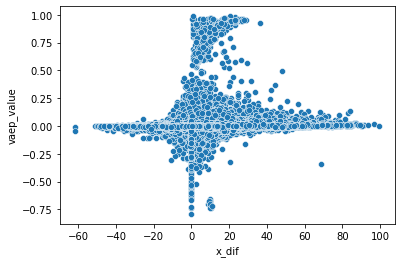

In [58]:
plt.figure()
sns.scatterplot(data=df_actions_zones, x='x_dif', y='vaep_value')
plt.show()

In [59]:
# plt.figure()
# sns.histplot(data=df_actions_zones, x='x_dif', y='vaep_value')
# plt.show()

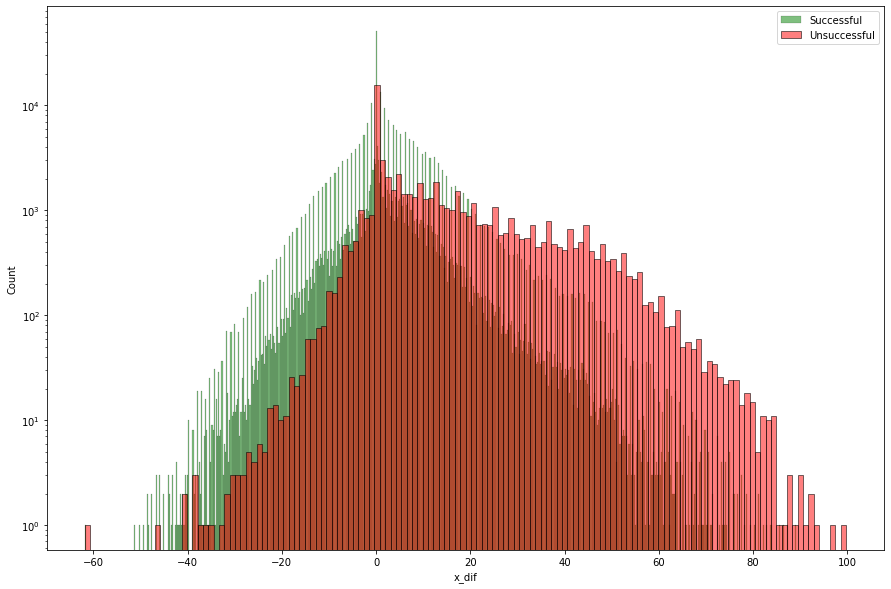

In [60]:
plt.figure(figsize=(15,10))
sns.histplot(df_actions_zones[df_actions_zones['result_name'] == 'success']['x_dif'], alpha=0.5, color='green', label='Successful')
sns.histplot(df_actions_zones[df_actions_zones['result_name'] != 'success']['x_dif'], alpha=0.5, color='red', label = 'Unsuccessful')

plt.yscale('log')
plt.legend()
plt.show()

#### Observations on successful moves and their length and direction

- Successful moves are shorter and backwards with a greater frequency
- Unsuccessful moves tend to be longer and with a forward direction - likely due to the riskier nature of those moves

In [61]:
heatmap_data =df_actions_zones[['end_pitch_zone', 'type_name']].value_counts().reset_index()

In [62]:
heatmap_data.rename(columns={0:'count'}, inplace=True)

In [63]:
heatmap_data = heatmap_data.pivot('end_pitch_zone', 'type_name', 'count')

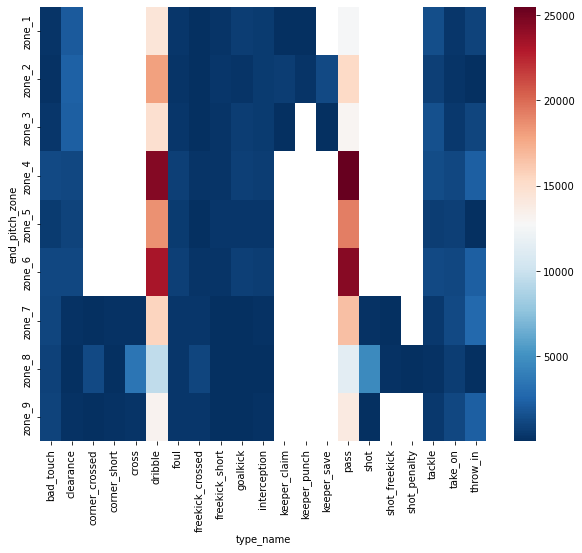

In [64]:
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, cmap='RdBu_r')
plt.show()

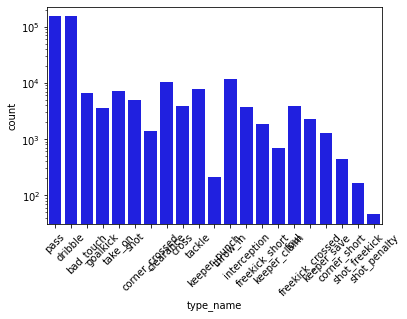

In [65]:
plt.figure()
sns.countplot(df_actions_zones['type_name'], color='blue')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

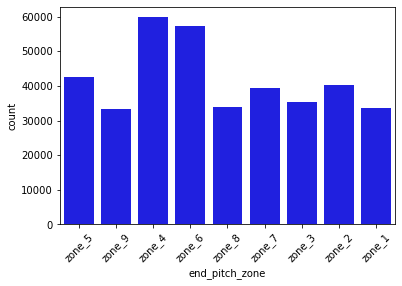

In [66]:
plt.figure()
sns.countplot(df_actions_zones['end_pitch_zone'], color='blue')
plt.xticks(rotation=45)
plt.show()

#### Observations on end zone and action type

- Passes and Dribbles are the most important moves in moving the ball about 
- Will focus the analysis on those 

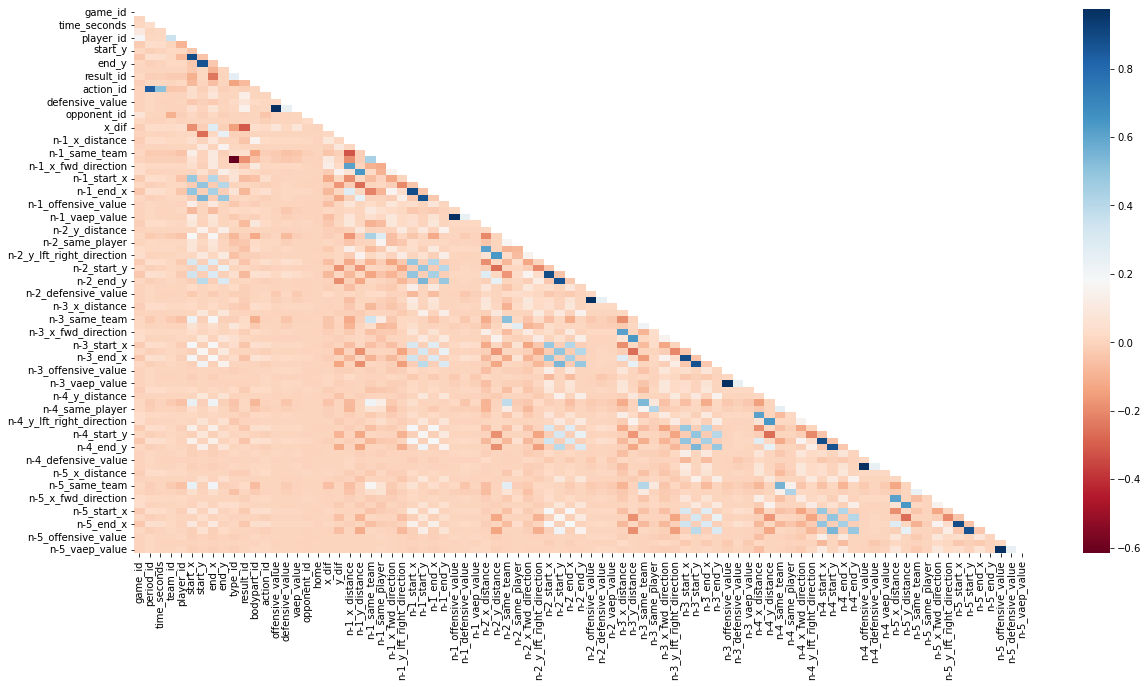

In [67]:
# find the correlation between the variables
corr = df_actions_zones.corr()

# plot the correlation matrix using a heatmap
plt.figure(figsize=(20,10))
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, cmap='RdBu')
plt.show()

## Creating Test Set

In [68]:
## Creating test set

VAEP_model = VAEP(nb_prev_actions=5)

# compute features and labels for each game
all_features_test, all_labels_test, all_actions_test = [], [], []
for game_id, game in tqdm(list(df_games_test.iterrows())):
    # load the game's events
    game_events = SBL.events(game_id)
    
    # convert the events to actions
    game_home_team_id = df_games_test.at[game_id, "home_team_id"]
    game_actions = spadl.statsbomb.convert_to_actions(game_events, game_home_team_id)
    game_actions = socceraction.spadl.add_names(game_actions)
    
    # compute features and labels
    all_actions_test.append(game_actions)
    all_features_test.append(VAEP_model.compute_features(game, game_actions))
    all_labels_test.append(VAEP_model.compute_labels(game, game_actions))

# combine all features and labels in a single dataframe
all_actions_test = pd.concat(all_actions_test)
all_features_test = pd.concat(all_features_test)
all_labels_test = pd.concat(all_labels_test)

# fit the model
VAEP_model.fit(all_features_test, all_labels_test)

VAEP_ratings_test = []
for game_id, game in tqdm(list(df_games_test.iterrows())):
    df_events = SBL.events(game_id)
    home_team_id = df_games_test.at[game_id, "home_team_id"]
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id)
    ratings = VAEP_model.rate(df_games_test.loc[game_id],df_actions)
    VAEP_ratings_test.append(ratings)
VAEP_ratings_test = pd.concat(VAEP_ratings_test)
rated_df_test = pd.concat([all_actions_test, VAEP_ratings_test], axis=1)

# Converting to left to right play
matches = []
for game_id, game in df_games_test.iterrows():
  
    # convert play left to right
    game_home_team_id = df_games_test.at[game_id, "home_team_id"]
    matches.append(spadl.play_left_to_right(rated_df_test[rated_df_test['game_id'] == game_id], home_team_id=game_home_team_id))

df_actions_zones_test = pd.concat(matches)

# Get players in test set
players_test = []
for game_id, game in tqdm(list(df_games_test.iterrows())):
    
    # load the games players
    players_test.append(SBL.players(game_id))


players_test = pd.concat(players_test, ignore_index=True)


#Create start and end zones
zones = []
end_zones = []

for i, row in df_actions_zones_test.iterrows():
    if ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_1')
    elif ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_2')
    elif ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_3')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_4')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_5')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_6')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_7')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_8')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_9')
    else:
        zones.append('no_zone')

for i, row in df_actions_zones_test.iterrows():
    if ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_1')
    elif ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_2')
    elif ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_3')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_4')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_5')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_6')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_7')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_8')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_9')
    else:
        end_zones.append('no_zone')

df_actions_zones_test['end_pitch_zone'] = end_zones
df_actions_zones_test['start_pitch_zone'] = zones

# opposition 
matches = list(df_actions_zones_test['game_id'].unique())
match_teams = {match: list(df_actions_zones_test[df_actions_zones_test['game_id'] == match]['team_id'].unique()) for match in matches}

df_actions_zones_test['opponent_id'] = [match_teams[k][1] if match_teams[k][0] == row['team_id'] else match_teams[k][0] \
     for i, row in df_actions_zones_test.iterrows() \
        for k, v in match_teams.items() \
            if row['game_id'] == k]

# update action type to pass/dribble/other to deal with class imbalance
df_actions_zones_test['type_name_encoded'] = ['pass' if x =='pass' else\
     ('dribble' if x =='dribble' else 'other')\
         for x in df_actions_zones_test['type_name']]

# Home or Away
df_actions_zones_test['home'] = [1 if np.array(df_games_test[df_games_test.index == row['game_id']]['home_team_id'] == row['team_id'])[0] \
    else 0 for i, row in df_actions_zones_test.iterrows() \
        for match in matches if row['game_id'] == match]

# x and y distance traveled 
df_actions_zones_test['x_dif'] = (df_actions_zones_test['end_x'] - df_actions_zones_test['start_x'])
df_actions_zones_test['y_dif'] = (df_actions_zones_test['end_y'] - df_actions_zones_test['start_y'])

#prior moves
print('Starting prior moves block')
for n in range(1,6):
    df_actions_zones_test[f'n-{n}_x_distance'] = df_actions_zones_test.groupby('game_id').shift(n)[['x_dif']]
    df_actions_zones_test[f'n-{n}_y_distance'] = df_actions_zones_test.groupby('game_id').shift(n)[['y_dif']]
    df_actions_zones_test[f'n-{n}_same_team'] = df_actions_zones_test.team_id.eq(df_actions_zones_test.team_id.shift(n))
    df_actions_zones_test[f'n-{n}_same_player'] = df_actions_zones_test.player_id.eq(df_actions_zones_test.player_id.shift(n))
    df_actions_zones_test[f'n-{n}_x_fwd_direction'] = [1 if row['x_dif'] > 0 else 0 for i, row in df_actions_zones_test.groupby('game_id').shift(n).iterrows()]
    df_actions_zones_test[f'n-{n}_y_lft_right_direction'] = [1 if row['y_dif'] > 0 else 0 for i, row in df_actions_zones_test.groupby('game_id').shift(n).iterrows()]
    df_actions_zones_test[f'n-{n}_start_pitch_zone'] = df_actions_zones_test.groupby('game_id').shift(n)[['start_pitch_zone']]
    df_actions_zones_test[f'n-{n}_end_pitch_zone'] = df_actions_zones_test.groupby('game_id').shift(n)[['end_pitch_zone']]
    df_actions_zones_test[f'n-{n}_start_x'] = df_actions_zones_test.groupby('game_id').shift(n)[['start_x']]
    df_actions_zones_test[f'n-{n}_start_y'] = df_actions_zones_test.groupby('game_id').shift(n)[['start_y']]
    df_actions_zones_test[f'n-{n}_end_x'] = df_actions_zones_test.groupby('game_id').shift(n)[['end_x']]
    df_actions_zones_test[f'n-{n}_end_y'] = df_actions_zones_test.groupby('game_id').shift(n)[['end_y']]
    df_actions_zones_test[f'n-{n}_type_name'] = df_actions_zones_test.groupby('game_id').shift(n)[['type_name']]
    df_actions_zones_test[f'n-{n}_type_name_encoded'] = df_actions_zones_test.groupby('game_id').shift(n)[['type_name_encoded']]
    df_actions_zones_test[f'n-{n}_result_name'] = df_actions_zones_test.groupby('game_id').shift(n)[['result_name']]
    df_actions_zones_test[f'n-{n}_bodypart_name'] = df_actions_zones_test.groupby('game_id').shift(n)[['bodypart_name']]
    df_actions_zones_test[f'n-{n}_offensive_value'] = df_actions_zones_test.groupby('game_id').shift(n)[['offensive_value']]
    df_actions_zones_test[f'n-{n}_defensive_value'] = df_actions_zones_test.groupby('game_id').shift(n)[['defensive_value']]
    df_actions_zones_test[f'n-{n}_vaep_value'] = df_actions_zones_test.groupby('game_id').shift(n)[['vaep_value']]

100%|██████████| 131/131 [04:37<00:00,  2.12s/it]


[0]	validation_0-auc:0.77861
[1]	validation_0-auc:0.78503
[2]	validation_0-auc:0.79694
[3]	validation_0-auc:0.79750
[4]	validation_0-auc:0.81551
[5]	validation_0-auc:0.82521
[6]	validation_0-auc:0.82737
[7]	validation_0-auc:0.82925
[8]	validation_0-auc:0.83155
[9]	validation_0-auc:0.83039
[10]	validation_0-auc:0.83143
[11]	validation_0-auc:0.83228
[12]	validation_0-auc:0.83266
[13]	validation_0-auc:0.83352
[14]	validation_0-auc:0.83421
[15]	validation_0-auc:0.83542
[16]	validation_0-auc:0.83690
[17]	validation_0-auc:0.83802
[18]	validation_0-auc:0.83937
[19]	validation_0-auc:0.84133
[20]	validation_0-auc:0.84183
[21]	validation_0-auc:0.84342
[22]	validation_0-auc:0.84643
[23]	validation_0-auc:0.84808
[24]	validation_0-auc:0.85020
[25]	validation_0-auc:0.85217
[26]	validation_0-auc:0.85275
[27]	validation_0-auc:0.85330
[28]	validation_0-auc:0.85343
[29]	validation_0-auc:0.85421
[30]	validation_0-auc:0.85458
[31]	validation_0-auc:0.85455
[32]	validation_0-auc:0.85414
[33]	validation_0-au

100%|██████████| 131/131 [02:05<00:00,  1.05it/s]


Starting prior moves block


In [69]:
df_actions_zones_test.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,offensive_value,defensive_value,vaep_value,end_pitch_zone,start_pitch_zone,opponent_id,type_name_encoded,home,x_dif,y_dif,n-1_x_distance,n-1_y_distance,n-1_same_team,n-1_same_player,n-1_x_fwd_direction,n-1_y_lft_right_direction,n-1_start_pitch_zone,n-1_end_pitch_zone,n-1_start_x,n-1_start_y,n-1_end_x,n-1_end_y,n-1_type_name,n-1_type_name_encoded,n-1_result_name,n-1_bodypart_name,n-1_offensive_value,n-1_defensive_value,n-1_vaep_value,n-2_x_distance,n-2_y_distance,n-2_same_team,n-2_same_player,n-2_x_fwd_direction,n-2_y_lft_right_direction,n-2_start_pitch_zone,n-2_end_pitch_zone,n-2_start_x,n-2_start_y,n-2_end_x,n-2_end_y,n-2_type_name,n-2_type_name_encoded,n-2_result_name,n-2_bodypart_name,n-2_offensive_value,n-2_defensive_value,n-2_vaep_value,n-3_x_distance,n-3_y_distance,n-3_same_team,n-3_same_player,n-3_x_fwd_direction,n-3_y_lft_right_direction,n-3_start_pitch_zone,n-3_end_pitch_zone,n-3_start_x,n-3_start_y,n-3_end_x,n-3_end_y,n-3_type_name,n-3_type_name_encoded,n-3_result_name,n-3_bodypart_name,n-3_offensive_value,n-3_defensive_value,n-3_vaep_value,n-4_x_distance,n-4_y_distance,n-4_same_team,n-4_same_player,n-4_x_fwd_direction,n-4_y_lft_right_direction,n-4_start_pitch_zone,n-4_end_pitch_zone,n-4_start_x,n-4_start_y,n-4_end_x,n-4_end_y,n-4_type_name,n-4_type_name_encoded,n-4_result_name,n-4_bodypart_name,n-4_offensive_value,n-4_defensive_value,n-4_vaep_value,n-5_x_distance,n-5_y_distance,n-5_same_team,n-5_same_player,n-5_x_fwd_direction,n-5_y_lft_right_direction,n-5_start_pitch_zone,n-5_end_pitch_zone,n-5_start_x,n-5_start_y,n-5_end_x,n-5_end_y,n-5_type_name,n-5_type_name_encoded,n-5_result_name,n-5_bodypart_name,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value
0,3775648,d062f895-1e3c-4fff-9937-fa3c81408bf7,1,0.0,968,15623.0,52.941176,34.344304,53.823529,32.450633,0,1,0,0,pass,success,foot,0.000000,-0.000000e+00,0.000000,zone_5,zone_5,2647,pass,0,0.882353,-1.893671,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3775648,0cb83915-5393-49da-9ade-106c9ef6a51e,1,0.0,968,15619.0,53.823529,32.450633,51.441176,33.741772,21,1,0,1,dribble,success,foot,-0.000368,-1.468954e-04,-0.000515,zone_5,zone_5,2647,dribble,0,-2.382353,1.291139,0.882353,-1.893671,True,False,1,0,zone_5,zone_5,52.941176,34.344304,53.823529,32.450633,pass,pass,success,foot,0.000000,-0.000000e+00,0.000000,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3775648,edd39d4f-cbcf-428d-a6f6-80914c176414,1,0.0,968,15619.0,51.441176,33.741772,36.176471,34.516456,0,1,0,2,pass,success,foot,-0.000269,1.386905e-04,-0.000130,zone_5,zone_5,2647,pass,0,-15.264706,0.774684,-2.382353,1.291139,True,True,0,1,zone_5,zone_5,53.823529,32.450633,51.441176,33.741772,dribble,dribble,success,foot,-0.000368,-1.468954e-04,-0.000515,0.882353,-1.893671,True,False,1,0,zone_5,zone_5,52.941176,34.344304,53.823529,32.450633,pass,pass,success,foot,0.000000,-0.000000,0.000000,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3775648,a281156d-530b-4cd5-90a7-e40004b135c3,1,1.0,968,10405.0,36.176471,34.516456,36.970588,33.483544,21,1,0,3,dribble,success,foot,0.000179,-2.19974

## Clustering players

In [70]:
clustering_df = df_actions_zones.groupby(['player_id','start_pitch_zone'])['start_x','start_y'].mean().reset_index()

clustering_df['frequency'] = df_actions_zones.groupby(['player_id', 'start_pitch_zone'])[['start_pitch_zone']].value_counts().values

In [71]:
clustering_df.head()

,player_id,start_pitch_zone,start_x,start_y,frequency
0,4633.0,zone_1,22.525882,16.078987,75
1,4633.0,zone_2,22.263363,38.728213,635
2,4633.0,zone_3,22.498169,54.164551,1349
3,4633.0,zone_4,48.187500,17.367018,72
4,4633.0,zone_5,47.773566,38.150974,717


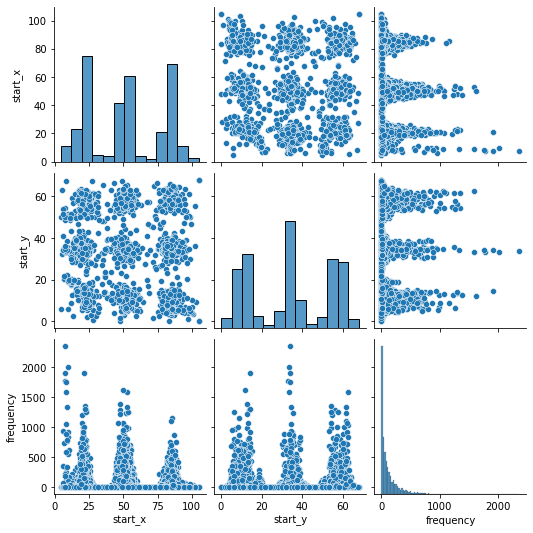

In [72]:
sns.pairplot(clustering_df[['start_pitch_zone', 'start_x', 'start_y','frequency']])
plt.show()

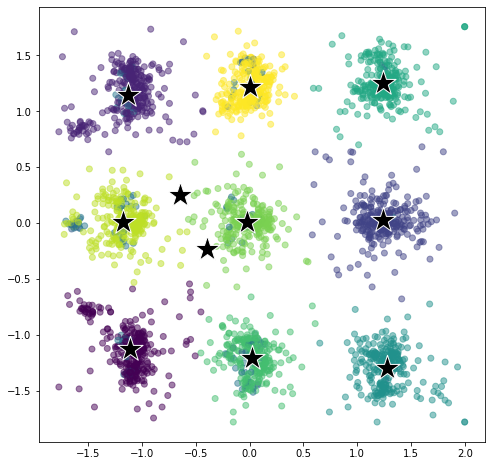

In [73]:
X = clustering_df[['start_x','start_y', 'frequency']]

ss = StandardScaler()
X = ss.fit_transform(X)

# Instantiate
k_means_model_2= KMeans(n_clusters=11)

# Fit
k_means_model_2.fit(X)
cluster_labels = k_means_model_2.predict(X)
centers = k_means_model_2.cluster_centers_

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], 
            c='black', marker="*", edgecolor="white", s=700)
plt.show()

In [74]:
clustering_df['cluster_labels'] = cluster_labels

In [75]:
# We will explore different values for k, and look at the scree plot ('elbow method') 
# using inertia. We will also look at the silhouette score

ks = np.arange(2, 99)
inertia_list = []
silhouette_score_list = []

for k in ks:

    # Instantiate
    my_kmeans = KMeans(n_clusters=k)
    
    # Fit (i.e. get clusters)
    y_labels = my_kmeans.fit_predict(X)
    
    # Append inertia
    inertia_list.append(my_kmeans.inertia_)

    # Append silhouette
    silhouette = silhouette_score(X, y_labels)
    silhouette_score_list.append(silhouette)

In [76]:
np.argmax(silhouette_score_list)
np.arange(2,88)[13]

15

In [77]:
# inertias = pd.Series(inertia_list)
# abs(inertias.pct_change().sort_values(ascending=True))

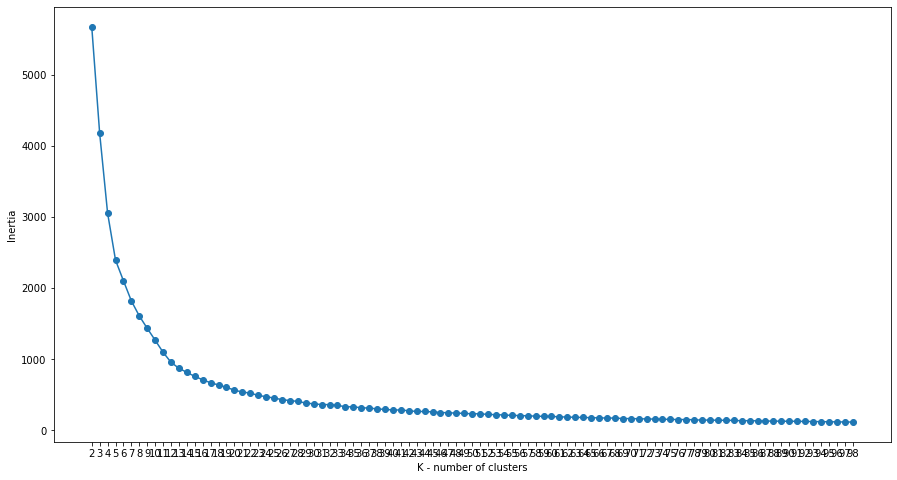

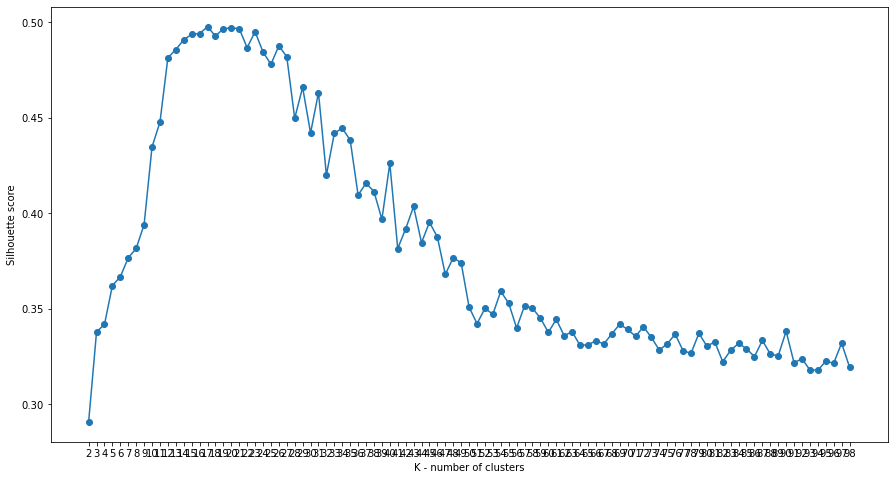

In [78]:
plt.figure(figsize=(15,8))

plt.plot(ks, inertia_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

plt.figure(figsize=(15,8))

plt.plot(ks, silhouette_score_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(ks)

plt.show()

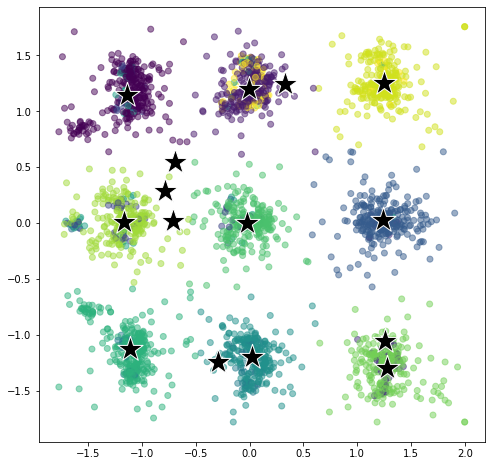

In [79]:
# Instantiate
k_means_model_2= KMeans(n_clusters=15)

# Fit
k_means_model_2.fit(X)
cluster_labels = k_means_model_2.predict(X)
centers = k_means_model_2.cluster_centers_

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], 
            c='black', marker="*", edgecolor="white", s=700)
plt.show()

In [80]:
X_with_labels = pd.DataFrame(X)
X_with_labels['labels'] = cluster_labels

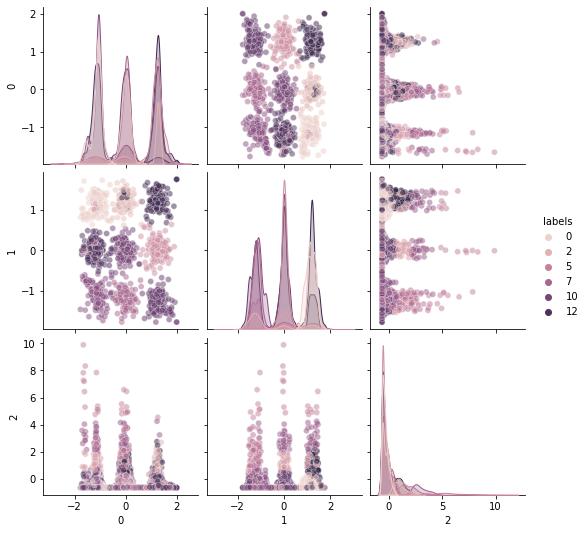

In [81]:
sns.pairplot(X_with_labels, hue='labels', plot_kws={'alpha': 0.5})
plt.show()

In [82]:
silhouette_scores = []
num_clusters = []
epsilons = np.arange(0.1, 1.2, 0.1)

for eps in epsilons:

    # Instantiate
    model = DBSCAN(eps=eps, min_samples=5)

    # Fit
    y_labels = model.fit_predict(X)
    
    # we disregard the noise label -1
    n_clusters = len(np.unique(y_labels[y_labels != -1]))
    print(f'eps = {eps} --- n_clusters: {n_clusters}')
    
    silhouette = silhouette_score(X, y_labels)
    silhouette_scores.append(silhouette)
    num_clusters.append(n_clusters)

eps = 0.1 --- n_clusters: 54
eps = 0.2 --- n_clusters: 19
eps = 0.30000000000000004 --- n_clusters: 4
eps = 0.4 --- n_clusters: 5
eps = 0.5 --- n_clusters: 3
eps = 0.6 --- n_clusters: 1
eps = 0.7000000000000001 --- n_clusters: 1
eps = 0.8 --- n_clusters: 1
eps = 0.9 --- n_clusters: 1
eps = 1.0 --- n_clusters: 1
eps = 1.1 --- n_clusters: 2


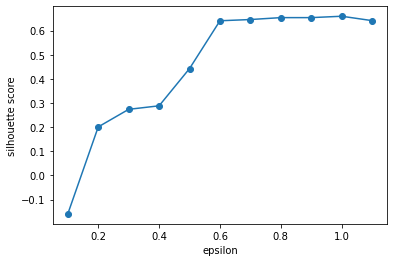

In [83]:
plt.figure()
plt.plot(epsilons, 
         silhouette_scores, 
         marker='o')
plt.xlabel('epsilon')
plt.ylabel('silhouette score')
plt.show()

## Feature Selection, Encoding and Pre-processing 

- Check class balances 
- Deal with imbalances 
- Encode categorical columns - we can do column transformations as part of GridSearch
- Split into Test and Train
- Scale Data


### TO DO: 

Person correlations for: 
- end_pitch_zone
- action_type
- xT
- VAEP

Need to one hot encode the categories

In [84]:
# from scipy import stats
# data = []
# num_col = df_actions_zones.select_dtypes(include=[np.number])

# for column in num_col.corr().columns:
#     data.append(stats.pearsonr(df_actions_zones['end_pitch_zone'], df_actions_zones[column]))

# end_zone_corr = pd.DataFrame(data, index=df_actions_zones.corr().columns, columns=['Correlation', 'P_value'])

# end_zone_corr.style.background_gradient(cmap='Oranges')

In [85]:
# from scipy import stats 
# data = []
# for column in corr:
#     data.append(stats.pearsonr(df_actions_zones['end_x'], df_actions_zones[column]))

# num_col_corr = pd.DataFrame(data, index=corr.columns, columns=['Correlation', 'P_value'])
# num_col_corr.style.background_gradient(cmap='Oranges')

In [86]:
modeling_train_df = df_actions_zones.copy()
modeling_test_df = df_actions_zones_test.copy()

## Player approach

In [87]:
players.groupby('player_id')['minutes_played'].sum().sort_values(ascending=False).head()

player_id
10185    3450
15709    3278
4633     3260
4658     3257
16376    3242
Name: minutes_played, dtype: int64

In [88]:
player_id = 4658

In [89]:
player_train_set = modeling_train_df[
    (modeling_train_df['player_id']==player_id)
    & (modeling_train_df['n-5_same_player']!=True)
    & (modeling_train_df['n-4_same_player']!=True)
    & (modeling_train_df['n-3_same_player']!=True)
    & (modeling_train_df['n-2_same_player']!=True)
    & (modeling_train_df['n-1_same_player']!=True)
    ]
player_train_set.shape

(2021, 122)

In [90]:
player_test_set = modeling_test_df[
    (modeling_test_df['player_id']==player_id)
    & (modeling_test_df['n-5_same_player']!=True)
    & (modeling_test_df['n-4_same_player']!=True)
    & (modeling_test_df['n-3_same_player']!=True)
    & (modeling_test_df['n-2_same_player']!=True)
    & (modeling_test_df['n-1_same_player']!=True)
    ]
player_test_set.shape

(1230, 122)

In [91]:
player_train_set.dropna(inplace=True)
player_train_set.shape

(1941, 122)

In [92]:
player_test_set.dropna(inplace=True)
player_test_set.shape

(1178, 122)

In [93]:
X_train = player_train_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_train_type = player_train_set['type_name_encoded']
y_train_end_zone = player_train_set['end_pitch_zone']

X_test = player_test_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_test_type = player_test_set['type_name_encoded']
y_test_end_zone = player_test_set['end_pitch_zone']

In [94]:
X_test.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,offensive_value,defensive_value,vaep_value,start_pitch_zone,opponent_id,home,x_dif,y_dif,n-1_x_distance,n-1_y_distance,n-1_same_team,n-1_same_player,n-1_x_fwd_direction,n-1_y_lft_right_direction,n-1_start_pitch_zone,n-1_end_pitch_zone,n-1_start_x,n-1_start_y,n-1_end_x,n-1_end_y,n-1_type_name,n-1_type_name_encoded,n-1_result_name,n-1_bodypart_name,n-1_offensive_value,n-1_defensive_value,n-1_vaep_value,n-2_x_distance,n-2_y_distance,n-2_same_team,n-2_same_player,n-2_x_fwd_direction,n-2_y_lft_right_direction,n-2_start_pitch_zone,n-2_end_pitch_zone,n-2_start_x,n-2_start_y,n-2_end_x,n-2_end_y,n-2_type_name,n-2_type_name_encoded,n-2_result_name,n-2_bodypart_name,n-2_offensive_value,n-2_defensive_value,n-2_vaep_value,n-3_x_distance,n-3_y_distance,n-3_same_team,n-3_same_player,n-3_x_fwd_direction,n-3_y_lft_right_direction,n-3_start_pitch_zone,n-3_end_pitch_zone,n-3_start_x,n-3_start_y,n-3_end_x,n-3_end_y,n-3_type_name,n-3_type_name_encoded,n-3_result_name,n-3_bodypart_name,n-3_offensive_value,n-3_defensive_value,n-3_vaep_value,n-4_x_distance,n-4_y_distance,n-4_same_team,n-4_same_player,n-4_x_fwd_direction,n-4_y_lft_right_direction,n-4_start_pitch_zone,n-4_end_pitch_zone,n-4_start_x,n-4_start_y,n-4_end_x,n-4_end_y,n-4_type_name,n-4_type_name_encoded,n-4_result_name,n-4_bodypart_name,n-4_offensive_value,n-4_defensive_value,n-4_vaep_value,n-5_x_distance,n-5_y_distance,n-5_same_team,n-5_same_player,n-5_x_fwd_direction,n-5_y_lft_right_direction,n-5_start_pitch_zone,n-5_end_pitch_zone,n-5_start_x,n-5_start_y,n-5_end_x,n-5_end_y,n-5_type_name,n-5_type_name_encoded,n-5_result_name,n-5_bodypart_name,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value
44,3775624,629b02f1-e29f-438b-b169-4dcf2d39a0e4,1,72.0,746,4658.0,28.588235,9.726582,28.588235,9.726582,21,1,0,44,dribble,success,foot,-0.000102,-0.000397,-0.000499,zone_1,1475,0,0.000000,0.000000,13.676471,4.303797,True,False,1,1,zone_1,zone_1,14.911765,5.422785,28.588235,9.726582,pass,pass,success,foot,0.000142,0.000393,0.000535,5.470588,-5.939241,True,False,1,0,zone_1,zone_1,9.441176,11.362025,14.911765,5.422785,dribble,dribble,success,foot,-0.000131,0.001921,0.001791,-4.500000,-14.202532,True,False,0,0,zone_2,zone_1,13.941176,25.564557,9.441176,11.362025,pass,pass,success,foot,0.000140,0.002329,0.002470,0.000000,0.000000,True,False,0,0,zone_2,zone_2,13.941176,25.564557,13.941176,25.564557,dribble,dribble,success,foot,-0.000196,-0.004112,-0.004307,10.941176,-2.754430,True,False,1,0,zone_2,zone_2,3.000000,28.318987,13.941176,25.564557,pass,pass,success,foot,-0.000216,0.002186,0.001969
95,3775624,d737ddc1-2cee-46d2-b684-8f90d3c912d8,1,189.0,746,4658.0,60.882353,40.197468,63.617647,27.113924,21,1,0,95,dribble,success,foot,-0.000954,-0.001487,-0.002441,zone_5,1475,0,2.735294,-13.083544,-4.588235,-7.918987,True,False,0,0,zone_6,zone_5,65.470588,48.116456,60.882353,40.197468,pass,pass,success,foot,-0.001988,0.000643,-0.001345,2.294118,-11.275949,True,False,1,0,zone_6,zone_6,63.176471,59.392405,65.470588,48.116456,dribble,dribble,success,foot,0.005894,-0.000418,0.005476,8.029412,28.749367,True,False,1,1,zone_5,zone_6,55.147059,30.643038,63.176471,59.392405,pass,pass,success,foot,0.000961,0.000389,0.001350,6.264706,2.754430,True,False,1,1,zone_5,zone_5,48.882353,27.888608,55.147059,30.643038,dribble,dribble,success,foot,0.002688,0.000624,0.003312,-4.676471,-21.174684,False,False,0,0,zone_6,zone_5,60.000000,62.060759,55.323529,40.886076,pass,pass,fail,foot,-0.002792,-0.001974,-0.004766
219,3775624,20388b02-e6bc-470f-aa4a-c480865c43bc,1,546.0,746,4658.0,74.647059,13.255696,74.294118,11.706329,21,1,0,219,dribble,success,foot,-0.001978,-0.000062,-0.002040,zone_7,1475,0,-0.352941,-1.549367,-2.911765,9.554430,True,False,0,1,zone_7,zone_7,77.558824,3.701266,74.647059,13.255696,pass,pass,success,foot,0.003732,-0.000051,0.003681,-1.058824,0

In [95]:
numeric_features = [
    'start_x',
    'start_y',
    'time_seconds',
    'n-1_x_distance',
    'n-1_y_distance',
    'n-1_start_x',
    'n-1_start_y',
    'n-1_end_x',
    'n-1_end_y',
    'n-1_offensive_value',
    'n-1_defensive_value',
    'n-1_vaep_value',
    'n-2_x_distance',
    'n-2_y_distance',
    'n-2_start_x',
    'n-2_start_y',
    'n-2_end_x',
    'n-2_end_y',
    'n-2_offensive_value',
    'n-2_defensive_value',
    'n-2_vaep_value',
    'n-3_x_distance',
    'n-3_y_distance',
    'n-3_start_x',
    'n-3_start_y',
    'n-3_end_x',
    'n-3_end_y',
    'n-3_offensive_value',
    'n-3_defensive_value',
    'n-3_vaep_value',
    'n-4_x_distance',
    'n-4_y_distance',
    'n-4_start_x',
    'n-4_start_y',
    'n-4_end_x',
    'n-4_end_y',
    'n-4_offensive_value',
    'n-4_defensive_value',
    'n-4_vaep_value',
    'n-5_x_distance',
    'n-5_y_distance',
    'n-5_start_x',
    'n-5_start_y',
    'n-5_end_x',
    'n-5_end_y',
    'n-5_offensive_value',
    'n-5_defensive_value',
    'n-5_vaep_value',
    ]

categorical_features = [
    'period_id',
    'start_pitch_zone',
    'opponent_id',
    'home',
    'n-1_same_team',
    'n-1_x_fwd_direction',
    'n-1_y_lft_right_direction',
    'n-1_start_pitch_zone',
    'n-1_end_pitch_zone',
    'n-1_type_name_encoded',
    'n-1_result_name',
    'n-1_bodypart_name',
    'n-2_same_team',
    'n-2_x_fwd_direction',
    'n-2_y_lft_right_direction',
    'n-2_start_pitch_zone',
    'n-2_end_pitch_zone',
    'n-2_type_name_encoded',
    'n-2_result_name',
    'n-2_bodypart_name',
    'n-3_same_team',
    'n-3_x_fwd_direction',
    'n-3_y_lft_right_direction',
    'n-3_start_pitch_zone',
    'n-3_end_pitch_zone',
    'n-3_type_name_encoded',
    'n-3_result_name',
    'n-3_bodypart_name',
    'n-4_same_team',
    'n-4_x_fwd_direction',
    'n-4_y_lft_right_direction',
    'n-4_start_pitch_zone',
    'n-4_end_pitch_zone',
    'n-4_type_name_encoded',
    'n-4_result_name',
    'n-4_bodypart_name',
    'n-5_same_team',
    'n-5_x_fwd_direction',
    'n-5_y_lft_right_direction',
    'n-5_start_pitch_zone',
    'n-5_end_pitch_zone',
    'n-5_type_name_encoded',
    'n-5_result_name',
    'n-5_bodypart_name',
    ]

# some of the features below will need dropping before training the model - but are required here for filtering dataset
# passthrough_features = [
#     'game_id',
#     'player_id',
#     ]

drop_features = [
    'original_event_id',
    'game_id',
    'player_id',
    'team_id',
    'end_x',
    'end_y',
    'type_id',
    'result_id',
    'bodypart_id',
    'action_id',
    'type_name',
    'result_name',
    'bodypart_name',
    'offensive_value',
    'defensive_value',
    'vaep_value',
    'x_dif',
    'y_dif',
    'n-1_same_player',
    'n-2_same_player',
    'n-3_same_player',
    'n-4_same_player',
    'n-5_same_player',
    ]

In [146]:
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [101]:
transformed_train_df = ct.fit_transform(X_train)
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
    
transformed_train_df = pd.DataFrame(transformed_train_df, columns=column_names)
transformed_train_df.head(20)

,start_x,start_y,time_seconds,n-1_x_distance,n-1_y_distance,n-1_start_x,n-1_start_y,n-1_end_x,n-1_end_y,n-1_offensive_value,n-1_defensive_value,n-1_vaep_value,n-2_x_distance,n-2_y_distance,n-2_start_x,n-2_start_y,n-2_end_x,n-2_end_y,n-2_offensive_value,n-2_defensive_value,n-2_vaep_value,n-3_x_distance,n-3_y_distance,n-3_start_x,n-3_start_y,n-3_end_x,n-3_end_y,n-3_offensive_value,n-3_defensive_value,n-3_vaep_value,n-4_x_distance,n-4_y_distance,n-4_start_x,n-4_start_y,n-4_end_x,n-4_end_y,n-4_offensive_value,n-4_defensive_value,n-4_vaep_value,n-5_x_distance,n-5_y_distance,n-5_start_x,n-5_start_y,n-5_end_x,n-5_end_y,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value,period_id_1,period_id_2,start_pitch_zone_zone_1,start_pitch_zone_zone_2,start_pitch_zone_zone_3,start_pitch_zone_zone_4,start_pitch_zone_zone_5,start_pitch_zone_zone_6,start_pitch_zone_zone_7,start_pitch_zone_zone_8,start_pitch_zone_zone_9,opponent_id_749,opponent_id_965,opponent_id_966,opponent_id_967,opponent_id_968,opponent_id_969,opponent_id_970,opponent_id_971,opponent_id_972,opponent_id_973,opponent_id_974,opponent_id_1475,home_0,home_1,n-1_same_team_False,n-1_same_team_True,n-1_x_fwd_direction_0,n-1_x_fwd_direction_1,n-1_y_lft_right_direction_0,n-1_y_lft_right_direction_1,n-1_start_pitch_zone_zone_1,n-1_start_pitch_zone_zone_2,n-1_start_pitch_zone_zone_3,n-1_start_pitch_zone_zone_4,n-1_start_pitch_zone_zone_5,n-1_start_pitch_zone_zone_6,n-1_start_pitch_zone_zone_7,n-1_start_pitch_zone_zone_8,n-1_start_pitch_zone_zone_9,n-1_end_pitch_zone_zone_1,n-1_end_pitch_zone_zone_2,n-1_end_pitch_zone_zone_3,n-1_end_pitch_zone_zone_4,n-1_end_pitch_zone_zone_5,n-1_end_pitch_zone_zone_6,n-1_end_pitch_zone_zone_7,n-1_end_pitch_zone_zone_8,n-1_end_pitch_zone_zone_9,n-1_type_name_encoded_dribble,n-1_type_name_encoded_other,n-1_type_name_encoded_pass,n-1_result_name_fail,n-1_result_name_offside,n-1_result_name_success,n-1_result_name_yellow_card,n-1_bodypart_name_foot,n-1_bodypart_name_head,n-1_bodypart_name_other,n-2_same_team_False,n-2_same_team_True,n-2_x_fwd_direction_0,n-2_x_fwd_direction_1,n-2_y_lft_right_direction_0,n-2_y_lft_right_direction_1,n-2_start_pitch_zone_zone_1,n-2_start_pitch_zone_zone_2,n-2_start_pitch_zone_zone_3,n-2_start_pitch_zone_zone_4,n-2_start_pitch_zone_zone_5,n-2_start_pitch_zone_zone_6,n-2_start_pitch_zone_zone_7,n-2_start_pitch_zone_zone_8,n-2_start_pitch_zone_zone_9,n-2_end_pitch_zone_zone_1,n-2_end_pitch_zone_zone_2,n-2_end_pitch_zone_zone_3,n-2_end_pitch_zone_zone_4,n-2_end_pitch_zone_zone_5,n-2_end_pitch_zone_zone_6,n-2_end_pitch_zone_zone_7,n-2_end_pitch_zone_zone_8,n-2_end_pitch_zone_zone_9,n-2_type_name_encoded_dribble,n-2_type_name_encoded_other,n-2_type_name_encoded_pass,n-2_result_name_fail,n-2_result_name_offside,n-2_result_name_owngoal,n-2_result_name_success,n-2_result_name_yellow_card,n-2_bodypart_name_foot,n-2_bodypart_name_head,n-2_bodypart_name_other,n-3_same_team_False,n-3_same_team_True,n-3_x_fwd_direction_0,n-3_x_fwd_direction_1,n-3_y_lft_right_direction_0,n-3_y_lft_right_direction_1,n-3_start_pitch_zone_zone_1,n-3_start_pitch_zone_zone_2,n-3_start_pitch_zone_zone_3,n-3_start_pitch_zone_zone_4,n-3_start_pitch_zone_zone_5,n-3_start_pitch_zone_zone_6,n-3_start_pitch_zone_zone_7,n-3_start_pitch_zone_zone_8,n-3_start_pitch_zone_zone_9,n-3_end_pitch_zone_zone_1,n-3_end_pitch_zone_zone_2,n-3_end_pitch_zone_zone_3,n-3_end_pitch_zone_zone_4,n-3_end_pitch_zone_zone_5,n-3_end_pitch_zone_zone_6,n-3_end_pitch_zone_zone_7,n-3_end_pitch_zone_zone_8,n-3_end_pitch_zone_zone_9,n-3_type_name_encoded_dribble,n-3_type_name_encoded_other,n-3_type_name_encoded_pass,n-3_result_name_fail,n-3_result_name_offside,n-3_result_name_success,n-3_result_name_yellow_card,n-3_bodypart_name_foot,n-3_bodypart_name_head,n-3_bodypart_name_other,n-4_same_team_False,n-4_same_team_True,n-4_x_fwd_direction_0,n-4_x_fwd_direction_1,n-4_y_lft_right_direction_0,n-4_y_lft_right_direction_1,n-4_start_pitch_zone_zone_1,n-4_start_pitch_zone_zone_2,n-4_start_pitch_zone_zone_3,

## Baseline Model

In [102]:
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

0.86913961875322
0.7275042444821732


In [103]:
pipe_svm = make_pipeline(ct, svm.SVC())
pipe_svm.fit(X_train, y_train_type)
print(pipe_svm.score(X_train, y_train_type))
print(pipe_svm.score(X_test, y_test_type))

0.8732612055641422
0.7461799660441426


In [106]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

1.0
0.6876061120543294


In [107]:
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train_end_zone)
print(pipe.score(X_train, y_train_end_zone))
print(pipe.score(X_test, y_test_end_zone))

0.8851107676455435
0.7037351443123939


In [108]:
pipe = make_pipeline(ct, svm.SVC())
pipe.fit(X_train, y_train_end_zone)
print(pipe.score(X_train, y_train_end_zone))
print(pipe.score(X_test, y_test_end_zone))

0.8593508500772797
0.7292020373514432


In [109]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_end_zone)
print(pipe.score(X_train, y_train_end_zone))
print(pipe.score(X_test, y_test_end_zone))

1.0
0.6511035653650254


## Baseline - Team Approach

In [110]:
df_games['away_team_id'].unique()

array([ 971,  969,  970,  968,  974,  965,  973,  966,  967,  746,  972,
       1475,  749])

In [111]:
team_train_set = modeling_train_df[modeling_train_df['team_id']==1475].dropna()
team_test_set = modeling_test_df[modeling_test_df['team_id']==1475].dropna()

X_train = team_train_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_train_type = team_train_set['type_name_encoded']
y_train_end_zone = team_train_set['end_pitch_zone']

X_test = team_test_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_test_type = team_test_set['type_name_encoded']
y_test_end_zone = team_test_set['end_pitch_zone']

In [112]:
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

0.7936051159072742
0.7771538145459526


In [113]:
pipe = make_pipeline(ct, svm.SVC())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

0.8379696243005595
0.7847326850203169


In [114]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

1.0
0.7230972926083185


In [115]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_end_zone)
print(pipe.score(X_train, y_train_end_zone))
print(pipe.score(X_test, y_test_end_zone))

1.0
0.5494224535451765


## Identifying transfers

In [116]:
transfer_players = ["Anna Patten","Carlotte Wubben-Moy","Lydia Williams","Noelle Maritz","Stephanie Catley","Fran Stenson","Mana Iwabuchi","Ramona Petzelberger","Anita Asante","Diana Silva","Freya Gregory","Stine Larsen","Caroline Siems","Lisa Weiß","Ruby Mace","Sophie Whitehouse","Veatriki Sarri","Ruesha Littlejohn","Emily Murphy","Jamie-Lee Napier","Rachel Corsie","Mollie Green","Chloe McCarron","Christie Murray","Emma Koivisto","Katie Startup","Rebekah Stott","Inessa Kaagman","Nora Heroum","Katie Robinson","Kiera Skeels","Molly Pike","Benedicte Håland","Emma Bissell","Aimee Palmer","Jemma Purfield","Laura Rafferty","Ella Rutherford","Zećira Mušović","Pernille Harder","Niamh Charles","Jessie Fleming","Melanie Leupolz","Alisha Lehmann","Jill Scott","Claire Emslie","Valérie Gauvin","Nicoline Sørensen","Damaris Egurrola","Poppy Pattinson","Rikke Sevecke","Ingrid Wold","Abby Dahlkemper","Alex Greenwood","Lucy Bronze","Samantha Mewis","Chloe Kelly","Esme Morgan","Emily Ramsey","Maria Thorisdottir","Fran Bentley","Alessia Russo","Ivana Fuso","Lucy Staniforth","Mollie Green","Carrie Jones","Ona Batlle","Danielle Carter","Deanna Cooper","Jessica Fishlock","Silvana Flores","Ga-Eul Jeon","Emma Mukandi","Erin Nayler","Lily Woodham","So-hyun Cho","Abbie McManus","Alanna Kennedy","Sophie Whitehouse","Alex Morgan","Shelina Zadorsky","Kerys Harrop","Aurora Mikalsen","Rachel Williams","Dagný Brynjarsdóttir","Anouk Denton","Jacynta Galabadaarachchi","Emily Ramsey","Lois Joel","Rachel Daly","Emily van Egmond","Hawa Cissoko","Kateřina Svitková","Mackenzie Arnold","Mia Cruickshank","Ruby Grant","Maz Pacheco"]


In [117]:
players[players['player_name'].isin(transfer_players)].groupby(['player_id','player_name'])['minutes_played'].sum().reset_index().sort_values(by='minutes_played',ascending=False).head(10)

,player_id,player_name,minutes_played
3,10172,Jill Scott,3125
14,18153,Alisha Lehmann,2852
4,15562,Lucy Staniforth,2584
7,15579,Inessa Kaagman,2516
13,17274,Poppy Pattinson,2350
5,15569,Kerys Harrop,2244
2,4648,Abbie McManus,2139
6,15570,Chloe Kelly,2113
9,15631,Niamh Charles,1642
11,16388,Ella Rutherford,1519


In [118]:
transfer_players_df = pd.DataFrame(transfer_players, columns=['player_name'])

In [119]:
list1 = transfer_players
list2 = players_test['player_name'].tolist()
threshold=70

# empty lists for storing the
# matches later
mat1 = []
mat2 = []

# iterating through list1 to extract 
# it's closest match from list2
for i in list1:
    mat1.append(process.extract(i, list2, limit=2))
transfer_players_df['matches'] = mat1

# iterating through the closest
# matches to filter out the
# maximum closest match

for j in transfer_players_df['matches']:
    
    for k in j:
        p = []
        if k[1] >= threshold:
            p.append(k[0])      
    mat2.append(",".join(p))
    
      
# storing the resultant matches 
# back to dframe1
transfer_players_df['matches'] = mat2
  
player_target_list = transfer_players_df['matches'].tolist()

In [120]:
player_target_df = players_test[(players_test['player_name'].isin(player_target_list)) & (players_test['starting_position_name']!='Goalkeeper')].groupby(['player_id','player_name'])['minutes_played'].sum().reset_index().sort_values(by='minutes_played',ascending=False)


In [121]:
player_target_df.head(5)

,player_id,player_name,minutes_played
43,24239,Jemma Elizabeth Purfield,2016
30,15579,Inessa Kaagman,2015
11,5076,Emily Louise van Egmond,1940
10,5074,Shelina Laura Zadorsky,1930
50,31534,Ella Toone,1887


In [122]:
players[players['player_id']==15579].head(1)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
276,19734,967,15579,Inessa Kaagman,None,8,True,21,Left Wing,94


In [123]:
players_test[players_test['player_id']==15579].head(1)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
100,3775570,965,15579,Inessa Kaagman,None,10,True,16,Left Midfield,95


In [124]:
team_train_set = modeling_train_df[modeling_train_df['team_id']==965].dropna()
team_test_set = modeling_test_df[(modeling_test_df['team_id']==965)&(modeling_test_df['player_id']==15579)].dropna()
# team_test_set = modeling_test_df[modeling_test_df['team_id']==973].dropna()

X_train = team_train_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_train_type = team_train_set['type_name_encoded']
y_train_end_zone = team_train_set['end_pitch_zone']

X_test = team_test_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_test_type = team_test_set['type_name_encoded']
y_test_end_zone = team_test_set['end_pitch_zone']

In [125]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

1.0
0.6776632302405499


In [126]:
pipe = make_pipeline(ct, RandomForestClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

1.0
0.7725085910652921


#### Get player data from seasons 1 & 2 - from their prior team

**Note:** training data did not contain this dataset

In [127]:
modeling_train_df[modeling_train_df['player_id']==24239].shape

(447, 122)

- predict player actions using team model trained on season 1&2 and new player's data from season 1&2 with their old team

In [128]:
predictions = pipe.predict(modeling_train_df[modeling_train_df['player_id']==15579].dropna())

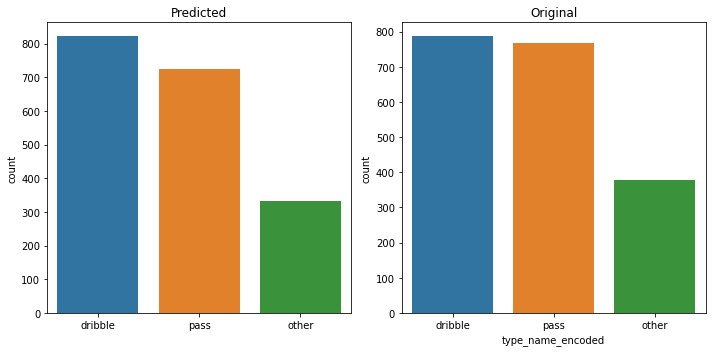

In [129]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(predictions)
plt.title('Predicted')
plt.subplot(1,2,2)
sns.countplot(modeling_train_df[modeling_train_df['player_id']==15579]['type_name_encoded'].dropna())
plt.title('Original')
plt.tight_layout()
plt.show()

In [130]:
prediction_matrix = modeling_train_df[modeling_train_df['player_id']==15579].dropna()[['type_name_encoded']]

# prediction_matrix.rename(columns={0:'Prediction'}, inplace=True)

In [131]:
prediction_matrix['prediction'] = predictions

In [132]:
prediction_matrix['hit'] = [1 if x['type_name_encoded'] == x['prediction'] else 0 for i,x in prediction_matrix.iterrows()]

In [133]:
prediction_matrix['hit'].mean()

0.7814992025518341

## VAEP Approach

```Create new column transform for this use case ```

In [134]:
numeric_features = [
    'start_x',
    'start_y',
    'end_x',
    'end_y',
    'x_dif',
    'y_dif',
    'time_seconds',
    'n-1_x_distance',
    'n-1_y_distance',
    'n-1_start_x',
    'n-1_start_y',
    'n-1_end_x',
    'n-1_end_y',
    'n-2_x_distance',
    'n-2_y_distance',
    'n-2_start_x',
    'n-2_start_y',
    'n-2_end_x',
    'n-2_end_y',
    'n-3_x_distance',
    'n-3_y_distance',
    'n-3_start_x',
    'n-3_start_y',
    'n-3_end_x',
    'n-3_end_y',
    'n-4_x_distance',
    'n-4_y_distance',
    'n-4_start_x',
    'n-4_start_y',
    'n-4_end_x',
    'n-4_end_y',
    'n-5_x_distance',
    'n-5_y_distance',
    'n-5_start_x',
    'n-5_start_y',
    'n-5_end_x',
    'n-5_end_y',
    ]

categorical_features = [
    'period_id',
    'start_pitch_zone',
    'end_pitch_zone',
    'opponent_id',
    'home',
    'type_name',
    'result_name',
    'bodypart_name',
    'n-1_same_team',
    'n-1_x_fwd_direction',
    'n-1_y_lft_right_direction',
    'n-1_start_pitch_zone',
    'n-1_end_pitch_zone',
    'n-1_result_name',
    'n-1_bodypart_name',
    'n-2_same_team',
    'n-2_x_fwd_direction',
    'n-2_y_lft_right_direction',
    'n-2_start_pitch_zone',
    'n-2_end_pitch_zone',
    'n-2_result_name',
    'n-2_bodypart_name',
    'n-3_same_team',
    'n-3_x_fwd_direction',
    'n-3_y_lft_right_direction',
    'n-3_start_pitch_zone',
    'n-3_end_pitch_zone',
    'n-3_result_name',
    'n-3_bodypart_name',
    'n-4_same_team',
    'n-4_x_fwd_direction',
    'n-4_y_lft_right_direction',
    'n-4_start_pitch_zone',
    'n-4_end_pitch_zone',
    'n-4_result_name',
    'n-4_bodypart_name',
    'n-5_same_team',
    'n-5_x_fwd_direction',
    'n-5_y_lft_right_direction',
    'n-5_start_pitch_zone',
    'n-5_end_pitch_zone',
    'n-5_result_name',
    'n-5_bodypart_name',
    'n-1_same_player',
    'n-2_same_player',
    'n-3_same_player',
    'n-4_same_player',
    'n-5_same_player',
    ]

# some of the features below will need dropping before training the model - but are required here for filtering dataset
# passthrough_features = [
#     'vaep_value'
#     ]

drop_features = [
    'original_event_id',
    'game_id',
    'player_id',
    'team_id',
    'type_id',
    'result_id',
    'bodypart_id',
    'action_id',
    'type_name_encoded',
    'n-5_type_name_encoded',
    'n-4_type_name_encoded',
    'n-3_type_name_encoded',
    'n-2_type_name_encoded',
    'n-1_type_name_encoded',
    'offensive_value',
    'defensive_value',
    'n-5_offensive_value',
    'n-5_defensive_value',
    'n-5_vaep_value',
    'n-4_offensive_value',
    'n-4_defensive_value',
    'n-4_vaep_value',
    'n-3_offensive_value',
    'n-3_defensive_value',
    'n-3_vaep_value',
    'n-2_offensive_value',
    'n-2_defensive_value',
    'n-2_vaep_value',
    'n-1_offensive_value',
    'n-1_defensive_value',
    'n-1_vaep_value'
    ]

In [135]:
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('drop', drop_features))

In [136]:
team_train_set = modeling_train_df[modeling_train_df['team_id']==965].dropna()
team_test_set = modeling_test_df[(modeling_test_df['team_id']==965)&(modeling_test_df['player_id']==15579)].dropna()
# team_test_set = modeling_test_df[modeling_test_df['team_id']==973].dropna()

X_train = team_train_set.drop(columns=['vaep_value'])
y_train_vaep = team_train_set['vaep_value']


X_test = team_test_set.drop(columns=['vaep_value'])
y_test_vaep = team_test_set['vaep_value']


In [137]:
transformed_train_df = ct.fit_transform(X_train)
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
    
transformed_train_df = pd.DataFrame(transformed_train_df, columns=column_names)
transformed_train_df.head(20)

,start_x,start_y,end_x,end_y,x_dif,y_dif,time_seconds,n-1_x_distance,n-1_y_distance,n-1_start_x,n-1_start_y,n-1_end_x,n-1_end_y,n-2_x_distance,n-2_y_distance,n-2_start_x,n-2_start_y,n-2_end_x,n-2_end_y,n-3_x_distance,n-3_y_distance,n-3_start_x,n-3_start_y,n-3_end_x,n-3_end_y,n-4_x_distance,n-4_y_distance,n-4_start_x,n-4_start_y,n-4_end_x,n-4_end_y,n-5_x_distance,n-5_y_distance,n-5_start_x,n-5_start_y,n-5_end_x,n-5_end_y,period_id_1,period_id_2,start_pitch_zone_zone_1,start_pitch_zone_zone_2,start_pitch_zone_zone_3,start_pitch_zone_zone_4,start_pitch_zone_zone_5,start_pitch_zone_zone_6,start_pitch_zone_zone_7,start_pitch_zone_zone_8,start_pitch_zone_zone_9,end_pitch_zone_zone_1,end_pitch_zone_zone_2,end_pitch_zone_zone_3,end_pitch_zone_zone_4,end_pitch_zone_zone_5,end_pitch_zone_zone_6,end_pitch_zone_zone_7,end_pitch_zone_zone_8,end_pitch_zone_zone_9,opponent_id_746,opponent_id_749,opponent_id_966,opponent_id_967,opponent_id_968,opponent_id_969,opponent_id_970,opponent_id_971,opponent_id_972,opponent_id_973,opponent_id_974,opponent_id_1475,home_0,home_1,type_name_bad_touch,type_name_clearance,type_name_corner_crossed,type_name_corner_short,type_name_cross,type_name_dribble,type_name_foul,type_name_freekick_crossed,type_name_freekick_short,type_name_goalkick,type_name_interception,type_name_keeper_claim,type_name_keeper_punch,type_name_keeper_save,type_name_pass,type_name_shot,type_name_shot_freekick,type_name_shot_penalty,type_name_tackle,type_name_take_on,type_name_throw_in,result_name_fail,result_name_offside,result_name_owngoal,result_name_success,result_name_yellow_card,bodypart_name_foot,bodypart_name_head,bodypart_name_other,n-1_same_team_False,n-1_same_team_True,n-1_x_fwd_direction_0,n-1_x_fwd_direction_1,n-1_y_lft_right_direction_0,n-1_y_lft_right_direction_1,n-1_start_pitch_zone_zone_1,n-1_start_pitch_zone_zone_2,n-1_start_pitch_zone_zone_3,n-1_start_pitch_zone_zone_4,n-1_start_pitch_zone_zone_5,n-1_start_pitch_zone_zone_6,n-1_start_pitch_zone_zone_7,n-1_start_pitch_zone_zone_8,n-1_start_pitch_zone_zone_9,n-1_end_pitch_zone_zone_1,n-1_end_pitch_zone_zone_2,n-1_end_pitch_zone_zone_3,n-1_end_pitch_zone_zone_4,n-1_end_pitch_zone_zone_5,n-1_end_pitch_zone_zone_6,n-1_end_pitch_zone_zone_7,n-1_end_pitch_zone_zone_8,n-1_end_pitch_zone_zone_9,n-1_result_name_fail,n-1_result_name_offside,n-1_result_name_owngoal,n-1_result_name_success,n-1_result_name_yellow_card,n-1_bodypart_name_foot,n-1_bodypart_name_head,n-1_bodypart_name_other,n-2_same_team_False,n-2_same_team_True,n-2_x_fwd_direction_0,n-2_x_fwd_direction_1,n-2_y_lft_right_direction_0,n-2_y_lft_right_direction_1,n-2_start_pitch_zone_zone_1,n-2_start_pitch_zone_zone_2,n-2_start_pitch_zone_zone_3,n-2_start_pitch_zone_zone_4,n-2_start_pitch_zone_zone_5,n-2_start_pitch_zone_zone_6,n-2_start_pitch_zone_zone_7,n-2_start_pitch_zone_zone_8,n-2_start_pitch_zone_zone_9,n-2_end_pitch_zone_zone_1,n-2_end_pitch_zone_zone_2,n-2_end_pitch_zone_zone_3,n-2_end_pitch_zone_zone_4,n-2_end_pitch_zone_zone_5,n-2_end_pitch_zone_zone_6,n-2_end_pitch_zone_zone_7,n-2_end_pitch_zone_zone_8,n-2_end_pitch_zone_zone_9,n-2_result_name_fail,n-2_result_name_offside,n-2_result_name_owngoal,n-2_result_name_success,n-2_result_name_yellow_card,n-2_bodypart_name_foot,n-2_bodypart_name_head,n-2_bodypart_name_other,n-3_same_team_False,n-3_same_team_True,n-3_x_fwd_direction_0,n-3_x_fwd_direction_1,n-3_y_lft_right_direction_0,n-3_y_lft_right_direction_1,n-3_start_pitch_zone_zone_1,n-3_start_pitch_zone_zone_2,n-3_start_pitch_zone_zone_3,n-3_start_pitch_zone_zone_4,n-3_start_pitch_zone_zone_5,n-3_start_pitch_zone_zone_6,n-3_start_pitch_zone_zone_7,n-3_start_pitch_zone_zone_8,n-3_start_pitch_zone_zone_9,n-3_end_pitch_zone_zone_1,n-3_end_pitch_zone_zone_2,n-3_end_pitch_zone_zone_3,n-3_end_pitch_zone_zone_4,n-3_end_pitch_zone_zone_5,n-3_end_pitch_zone_zone_6,n-3_end_pitch_zone_zone_7,n-3_end_pitch_zone_zone_8,n-3_end_pitch_zone_zone_9,n-3_result_name_fail,n-3_result_name_offside,n-3_result_name_owngoal,n-3_result_name_

In [139]:
pipe = make_pipeline(ct, LinearRegression())
pipe.fit(X_train, y_train_vaep)
print(pipe.score(X_train, y_train_vaep))
print(pipe.score(X_test, y_test_vaep))

0.10261779233619406
-6.68816836815701e+20


In [140]:
pipe = make_pipeline(ct, DecisionTreeRegressor())
pipe.fit(X_train, y_train_vaep)
print(pipe.score(X_train, y_train_vaep))
print(pipe.score(X_test, y_test_vaep))

1.0
0.7166146028032443


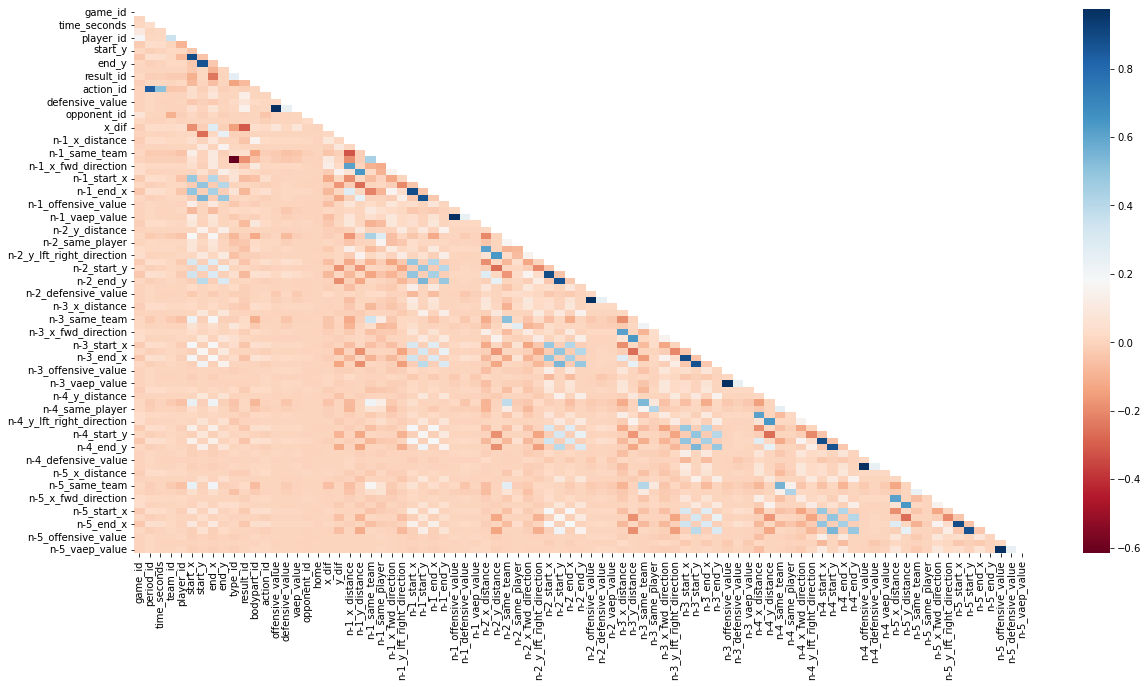

In [141]:
# find the correlation between the variables
corr = modeling_train_df.corr()

# plot the correlation matrix using a heatmap
plt.figure(figsize=(20,10))
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, cmap='RdBu')
plt.show()

In [142]:
from scipy import stats
data = []
num_col = transformed_train_df.dropna().select_dtypes(include=[np.number])

for column in num_col.corr().columns:
    data.append(stats.pearsonr(y_train_vaep, num_col[column]))

end_zone_corr = pd.DataFrame(data, index=num_col.corr().columns, columns=['Correlation', 'P_value'])

end_zone_corr.style.background_gradient(cmap='Oranges')

,Correlation,P_value
start_x,0.011720,0.050969
start_y,0.003507,0.559262
end_x,0.046580,0.000000
end_y,0.003554,0.553963
x_dif,0.073717,0.000000
y_dif,0.000153,0.979654
time_seconds,0.010071,0.093531
n-1_x_distance,0.014841,0.013455
n-1_y_distance,-0.004897,0.414841
n-1_start_x,-0.002220,0.711613


In [143]:
end_zone_corr[end_zone_corr['P_value']< 0.005].style.background_gradient(cmap='Oranges')

,Correlation,P_value
end_x,0.046580,0.000000
x_dif,0.073717,0.000000
n-2_start_x,0.024814,0.000036
n-2_end_x,0.023100,0.000120
n-4_y_distance,-0.024955,0.000032
n-4_start_y,0.018940,0.001610
start_pitch_zone_zone_8,0.033621,0.000000
end_pitch_zone_zone_8,0.082211,0.000000
opponent_id_969,0.018996,0.001559
type_name_bad_touch,-0.066002,0.000000


To do: 
- Pearson correlation between target and model variables
- Find an alternative to dropping nas

## Modeling 

**Approach to modeling:**

1. Pick a player to replace in a team
2. Get the top players in their cluster as potential replacements 
3. Fit a model for each of the scouted players 
    - use only that player's data to fit the model
    - the models will predict their next location and the action they take 
    - the parameters in the model should cover the player characteristics and team characteristics. For example, the 5 past moves cover what the team does, and how then the player reacts to those. The player action is the predicted target 

**Model validation and testing approach:**

- Of the scouted players, find those that have undergone a transfer in season 3 in our data set - use season 3 data to test our predictions. 
- Score the model based on the real data from their new team


**Models to train and test:**

- Baseline model for logistic regression for next action and end pitch location
- Random Forest classifier for end pitch location and next action 
- xGBoost classifier for end pitch location and next action 
- Random Forest regressor for end_x and end_y location 
- xGBoost regressor for enx_x and end_y location

## Grid Search with Cross-Validation

## Scoring output

**Create a class that:**

1. Takes in a player id 
2. Slices the dataset for this player
3. Clusters most similar players 
4. Take the top 3 players 
5. Slices the datasets for each player
6. Fits a model for each 
7. Run a prediction based on the original player dataset
8. Scores the results 

add in:

kNN
SVM
DT
Random Forest
xGBoost

with a cv 5

Run it for End-zone 
Run it for Next Action
Run it for VAEP Regression 
Run it for xT regression (build the dataset)

add in kbest
add in PCA

In [152]:
type(modeling_train_df)

pandas.core.frame.DataFrame

In [153]:
def create_team_data(team_col: str, team_id: int, player_col: str, player_id: int, train_df, test_df, target: str):
    
    # get the team and player data
    team_train_set = train_df[train_df[team_col]==team_id].dropna()
    team_test_set = test_df[(test_df[team_col]==team_id)&(test_df[team_col]==player_id)].dropna()

    # get the train data
    X_train = team_train_set.drop(columns=[target])
    y_train = team_train_set[target]

    # get the test data
    X_test = team_test_set.drop(columns=[target])
    y_test = team_test_set[target]

    return X_train, y_train, X_test, y_test

In [144]:
# define placeholder pipeline
estimator = [
    ('scaler', StandardScaler()),
    ('dim_reducer', PCA()),
    ('model', LinearRegression())
]
pipe = Pipeline(estimator, ct)
# Define a parameter grid
param_grid = [
    # l1 without PCA
    {
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'dim_reducer': [None],
        'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
        'model__C': []
    },
    
    # l1 with PCA
    {
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'dim_reducer': [PCA()],
        'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
        'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
        'model__C': []
    },
    
    # l2 (default) without PCA
    {
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'dim_reducer': [None],
        'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
        'model__C': c_values
    },
    
    # l2 (default) with PCA
    {
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'dim_reducer': [PCA()],
        'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
        'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
        'model__C': c_values
    },

    {
        'model': [kNN()],
        'scaler': [StandardScaler()],
        'dim_reducer':[PCA()],
        'model__C': [10**x for x in range(-5, 6)],
        'model__gamma': [10**x for x in range(-3, 3)]
    },
    {
        'model': [DecisionTreeRegressor()],
        'scaler': [StandardScaler()],
        'dim_reducer':[PCA()],
        'model__C': [10**x for x in range(-5, 6)],
        'model__gamma': [10**x for x in range(-3, 3)]
    },
    {
        'model': [RandomForestClassifier()],
        'scaler': [StandardScaler()],
        'dim_reducer':[PCA()],
        'model__C': [10**x for x in range(-5, 6)],
        'model__gamma': [10**x for x in range(-3, 3)]
    },
    {
        'model': [xgb()],
        'scaler': [StandardScaler()],
        'dim_reducer':[PCA()],
        'model__C': [10**x for x in range(-5, 6)],
        'model__gamma': [10**x for x in range(-3, 3)]
    }
]



# Instantiate a gridsearch
grid = GridSearchCV(pipe, param_grid, cv = 5, verbose = 2)
fitted_grid = grid.fit(X_train, y_train)

fitted_grid.best_estimator_
fitted_grid.score(X_test, y_test)

SyntaxError: unmatched ']' (3473410111.py, line 72)